In [ ]:
# === [KÖK AYAR] Proje içi indirilecek klasörler (ENV önce gelmeli) ===
import os
from pathlib import Path

PROJECT_DIR = Path.cwd()
DATA_DIR    = PROJECT_DIR / "data"
TFDS_DIR    = DATA_DIR / "tfds"   # TFDS (SVHN vs.) buraya insin
KERAS_DIR   = DATA_DIR / "keras"  # keras.datasets (MNIST/fMNIST/CIFAR10) buraya insin

# Sadece proje içine indir/sakla:
os.environ["TFDS_DATA_DIR"] = str(TFDS_DIR)
os.environ["KERAS_HOME"]    = str(KERAS_DIR)

TFDS_DIR.mkdir(parents=True, exist_ok=True)
KERAS_DIR.mkdir(parents=True, exist_ok=True)

# ===============================================================
#@title Datasets: synthetic + MNIST/fMNIST (çoklu ikili) + CIFAR10 + SVHN + **Paper Synthetic A/B/C**

import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

# SVHN (tfds) kurulum/ithalat
try:
    import tensorflow_datasets as tfds
except Exception:
    # Not: Notebook'ta pip gerekir; VS Code kernel'i için uygundur.
    !pip -q install tensorflow-datasets
    import tensorflow_datasets as tfds

# Tamamen lokal indir (GCS mirror kapalı)
# tfds.core.utils.gcs_utils.set_gcs_disabled(True)

RNG = np.random.default_rng(42)
OUT = Path('data'); OUT.mkdir(exist_ok=True)

def save_npz(X_train, y_train, X_test, y_test, name):
    p = OUT / f"{name}.npz"
    np.savez_compressed(p, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    print("saved", p, X_train.shape, X_test.shape)

# =========================
# ---------- Synthetic (existing) ----------
# A: Moons
X_all, y_all = make_moons(n_samples=10000, noise=0.30, random_state=0)
idx = RNG.permutation(len(X_all))
tr, te = idx[:1000], idx[1000:2000]
save_npz(X_all[tr], y_all[tr], X_all[te], y_all[te], "synthetic_A_moons_1k_each")
save_npz(X_all, y_all, X_all, y_all, "synthetic_A_moons_full10k")

# B: Circles
Xb, yb = make_circles(n_samples=2000, noise=0.10, factor=0.5, random_state=1)
save_npz(Xb[:1000], yb[:1000], Xb[1000:2000], yb[1000:2000], "synthetic_B_circles_1k_each")

# C: Blobs
Xc, yc = make_blobs(n_samples=2000, centers=[(-1,0),(1,0)], cluster_std=[1.1,1.1], random_state=2)
save_npz(Xc[:1000], yc[:1000], Xc[1000:2000], yc[1000:2000], "synthetic_C_blobs_1k_each")

# =========================
# ---------- Paper Synthetic A/B/C (ADDED) ----------

def _split_balanced(X0, X1, n_train_each=1000, n_test_each=1000, rng=RNG):
    """X0, X1: (N0, d) ve (N1, d). Her sınıftan n_train_each + n_test_each ayırır."""
    assert len(X0) >= n_train_each + n_test_each and len(X1) >= n_train_each + n_test_each
    i0 = rng.permutation(len(X0))
    i1 = rng.permutation(len(X1))
    X0_tr = X0[i0[:n_train_each]]; X0_te = X0[i0[n_train_each:n_train_each+n_test_each]]
    X1_tr = X1[i1[:n_train_each]]; X1_te = X1[i1[n_train_each:n_train_each+n_test_each]]
    Xtr = np.vstack([X0_tr, X1_tr]); ytr = np.hstack([np.zeros(len(X0_tr), dtype=np.int64), np.ones(len(X1_tr), dtype=np.int64)])
    Xte = np.vstack([X0_te, X1_te]); yte = np.hstack([np.zeros(len(X0_te), dtype=np.int64), np.ones(len(X1_te), dtype=np.int64)])
    # karıştır
    p_tr = rng.permutation(len(Xtr)); p_te = rng.permutation(len(Xte))
    return Xtr[p_tr], ytr[p_tr], Xte[p_te], yte[p_te]

# --- Paper Synthetic A: "Sinusoidal bands" (2D)
def make_sin_bands(n_each=4000, x_range=(-np.pi, np.pi), offset=0.9, noise=0.15, rng=RNG):
    xs0 = rng.uniform(x_range[0], x_range[1], size=n_each)
    xs1 = rng.uniform(x_range[0], x_range[1], size=n_each)
    y0 = np.sin(xs0) - offset + rng.normal(0, noise, size=n_each)
    y1 = np.sin(xs1) + offset + rng.normal(0, noise, size=n_each)
    X0 = np.stack([xs0, y0], axis=1)
    X1 = np.stack([xs1, y1], axis=1)
    return X0, X1

X0, X1 = make_sin_bands(n_each=4000, offset=0.9, noise=0.12)
Xa_tr, ya_tr, Xa_te, ya_te = _split_balanced(X0, X1, 1000, 1000)
save_npz(Xa_tr, ya_tr, Xa_te, ya_te, "paper_syn_A_sin_bands_1k_each")

# --- Paper Synthetic B: "Two spirals" (2D, topolojik dolaşıklık)
def make_two_spirals(n_each=4000, noise=0.5, turns=3, rng=RNG):
    # klasik çift-spiral: r = a*theta
    theta = rng.uniform(0.0, turns * np.pi, size=n_each)
    a = 0.5
    r = a * theta
    x0 = r * np.cos(theta) + rng.normal(0, noise, size=n_each)
    y0 = r * np.sin(theta) + rng.normal(0, noise, size=n_each)
    # ikinci spiral π faz kaydır
    theta2 = theta + np.pi
    r2 = a * theta2
    x1 = r2 * np.cos(theta2) + rng.normal(0, noise, size=n_each)
    y1 = r2 * np.sin(theta2) + rng.normal(0, noise, size=n_each)
    X0 = np.stack([x0, y0], axis=1)
    X1 = np.stack([x1, y1], axis=1)
    return X0, X1

X0, X1 = make_two_spirals(n_each=4000, noise=0.35, turns=3.5)
Xb_tr, yb_tr, Xb_te, yb_te = _split_balanced(X0, X1, 1000, 1000)
save_npz(Xb_tr, yb_tr, Xb_te, yb_te, "paper_syn_B_two_spirals_1k_each")

# --- Paper Synthetic C: "Sine surface vs plane" (3D)
def make_sine_surface_vs_plane(n_each=6000, xy_range=(-2*np.pi, 2*np.pi), noise_xy=0.05, noise_z=0.12, rng=RNG):
    # Plane (class 0)
    x0 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    y0 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    z0 = rng.normal(0, noise_z, size=n_each)  # z ~ 0
    X0 = np.stack([x0 + rng.normal(0, noise_xy, size=n_each),
                   y0 + rng.normal(0, noise_xy, size=n_each),
                   z0], axis=1)
    # Sine surface (class 1)
    x1 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    y1 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    z1_mean = np.sin(x1) + 0.5*np.sin(y1)
    z1 = z1_mean + rng.normal(0, noise_z, size=n_each)
    X1 = np.stack([x1 + rng.normal(0, noise_xy, size=n_each),
                   y1 + rng.normal(0, noise_xy, size=n_each),
                   z1], axis=1)
    return X0, X1

X0, X1 = make_sine_surface_vs_plane(n_each=6000, xy_range=(-3.0, 3.0), noise_xy=0.03, noise_z=0.08)
Xc_tr, yc_tr, Xc_te, yc_te = _split_balanced(X0, X1, 1000, 1000)
save_npz(Xc_tr, yc_tr, Xc_te, yc_te, "paper_syn_C_sine_surface_vs_plane_1k_each")

# =========================
# ---------- Helpers ----------
def subset_digits_flat(x, y, pos, neg):
    sel = np.where((y==pos)|(y==neg))[0]
    X = x[sel].astype('float32')/255.0
    yb = (y[sel]==pos).astype('int64')
    X = X.reshape((X.shape[0], -1))
    return X, yb

def _tfds_to_numpy(ds, take=None):
    Xs, ys = [], []
    for i, ex in enumerate(tfds.as_numpy(ds)):
        if (take is not None) and (i>=take): break
        Xs.append(ex['image'])
        ys.append(ex['label'])
    X = np.stack(Xs).astype('float32')/255.0
    y = np.array(ys).astype('int64')
    return X, y

def subset_pair(X, y, a, b):
    m = (y==a)|(y==b)
    X = X[m]; y = y[m]
    yb = (y==a).astype('int64')
    return X.reshape((X.shape[0], -1)), yb

# =========================
# ---------- MNIST (çoklu ikili) ----------
(Xtr, ytr), (Xte, yte) = mnist.load_data()
mnist_pairs = [
    (1,7,'mnist_1v7'),
    (6,8,'mnist_6v8'),
    (0,8,'mnist_0v8'),
    (2,7,'mnist_2v7'),
    (3,5,'mnist_3v5'),
    (4,9,'mnist_4v9'),
]
for a,b,name in mnist_pairs:
    Xtr2, ytr2 = subset_digits_flat(Xtr, ytr, a, b)
    Xte2, yte2 = subset_digits_flat(Xte, yte, a, b)
    save_npz(Xtr2, ytr2, Xte2, yte2, name)

# ---------- Fashion-MNIST (çoklu ikili) ----------
(Xtr, ytr), (Xte, yte) = fashion_mnist.load_data()
fmnist_pairs = [
    (5,9,'fmnist_sandal_v_boot'),
    (6,4,'fmnist_shirt_v_coat'),
    (0,6,'fmnist_tshirt_v_shirt'),
]
for a,b,name in fmnist_pairs:
    Xtr2, ytr2 = subset_digits_flat(Xtr, ytr, a, b)
    Xte2, yte2 = subset_digits_flat(Xte, yte, a, b)
    save_npz(Xtr2, ytr2, Xte2, yte2, name)

# ---------- CIFAR-10 (iki ikili) ----------
# labels: 0=airplane,1=automobile,2=bird,3=cat,4=deer,5=dog,6=frog,7=horse,8=ship,9=truck
(Xtr, ytr), (Xte, yte) = cifar10.load_data()
ytr = ytr.ravel().astype('int64'); yte = yte.ravel().astype('int64')
# cat(3) vs dog(5)
Xtr2, ytr2 = subset_pair(Xtr, ytr, 3, 5)
Xte2, yte2 = subset_pair(Xte, yte, 3, 5)
save_npz(Xtr2, ytr2, Xte2, yte2, "cifar10_cat_v_dog")
# automobile(1) vs truck(9)
Xtr2, ytr2 = subset_pair(Xtr, ytr, 1, 9)
Xte2, yte2 = subset_pair(Xte, yte, 1, 9)
save_npz(Xtr2, ytr2, Xte2, yte2, "cifar10_car_v_truck")

# ---------- SVHN (iki ikili) ----------
# Not: data_dir=str(TFDS_DIR) + try_gcs=False -> sadece lokal
svhn_train = tfds.load('svhn_cropped', split='train', shuffle_files=False, try_gcs=False, data_dir=str(TFDS_DIR))
svhn_test  = tfds.load('svhn_cropped', split='test',  shuffle_files=False, try_gcs=False, data_dir=str(TFDS_DIR))
Xtr, ytr = _tfds_to_numpy(svhn_train)  # büyükse ileride örnekleme ekleyebiliriz
Xte, yte = _tfds_to_numpy(svhn_test)
# 1 vs 7
Xtr2, ytr2 = subset_pair(Xtr, ytr, 1, 7)
Xte2, yte2 = subset_pair(Xte, yte, 1, 7)
save_npz(Xtr2, ytr2, Xt e2, yte2, "svhn_1v7")
# 3 vs 8
Xtr2, ytr2 = subset_pair(Xtr, ytr, 3, 8)
Xte2, yte2 = subset_pair(Xte, yte, 3, 8)
save_npz(Xtr2, ytr2, Xte2, yte2, "svhn_3v8")

# (İsteğe bağlı) Doğrulama mesajları:
print("TFDS_DATA_DIR  ->", TFDS_DIR)
print("KERAS_HOME     ->", KERAS_DIR)


saved data\synthetic_A_moons_1k_each.npz (1000, 2) (1000, 2)
saved data\synthetic_A_moons_full10k.npz (10000, 2) (10000, 2)
saved data\synthetic_B_circles_1k_each.npz (1000, 2) (1000, 2)
saved data\synthetic_C_blobs_1k_each.npz (1000, 2) (1000, 2)
saved data\paper_syn_A_sin_bands_1k_each.npz (2000, 2) (2000, 2)
saved data\paper_syn_B_two_spirals_1k_each.npz (2000, 2) (2000, 2)
saved data\paper_syn_C_sine_surface_vs_plane_1k_each.npz (2000, 3) (2000, 3)
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
saved data\mnist_1v7.npz (13007, 784) (2163, 784)
saved data\mnist_6v8.npz (11769, 784) (1932, 784)
saved data\mnist_0v8.npz (11774, 784) (1954, 784)
saved data\mnist_2v7.npz (12223, 784) (2060, 784)
saved data\mnist_3v5.npz (11552, 784) (1902, 784)
saved data\mnist_4v9.npz (11791, 784) (1991, 784)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
save

s:\cihan\cihan\Ricci-Flow-Deep-Learning---Graduation-Project\.venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 3/3 [03:09<00:00, 63.33s/ url]


Dataset svhn_cropped downloaded and prepared to s:\cihan\cihan\Ricci-Flow-Deep-Learning---Graduation-Project\data\tfds\svhn_cropped\3.1.0. Subsequent calls will reuse this data.
saved data\svhn_1v7.npz (19456, 3072) (7118, 3072)
saved data\svhn_3v8.npz (13542, 3072) (4542, 3072)
TFDS_DATA_DIR  -> s:\cihan\cihan\Ricci-Flow-Deep-Learning---Graduation-Project\data\tfds
KERAS_HOME     -> s:\cihan\cihan\Ricci-Flow-Deep-Learning---Graduation-Project\data\keras



=== cifar10_car_v_truck ===
train: (10000, 3072), classes: [0, 1], counts: {0: 5000, 1: 5000}


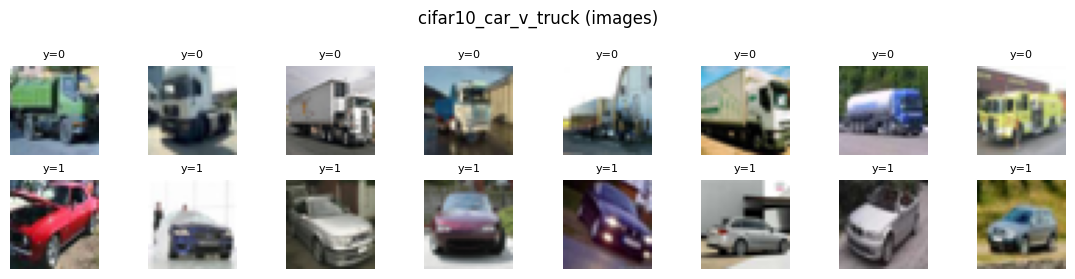


=== cifar10_cat_v_dog ===
train: (10000, 3072), classes: [0, 1], counts: {0: 5000, 1: 5000}


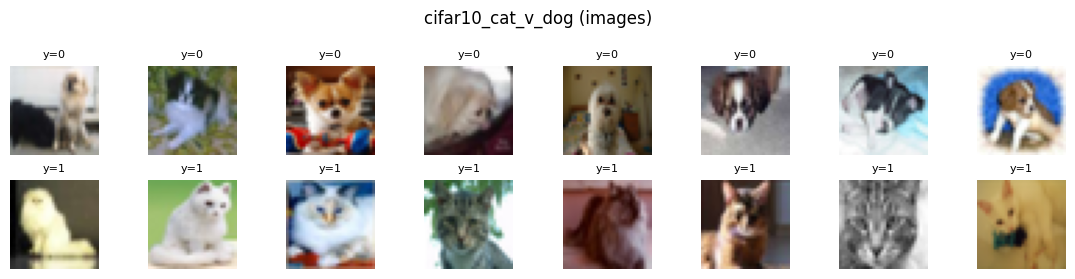


=== fmnist_sandal_v_boot ===
train: (12000, 784), classes: [0, 1], counts: {0: 6000, 1: 6000}


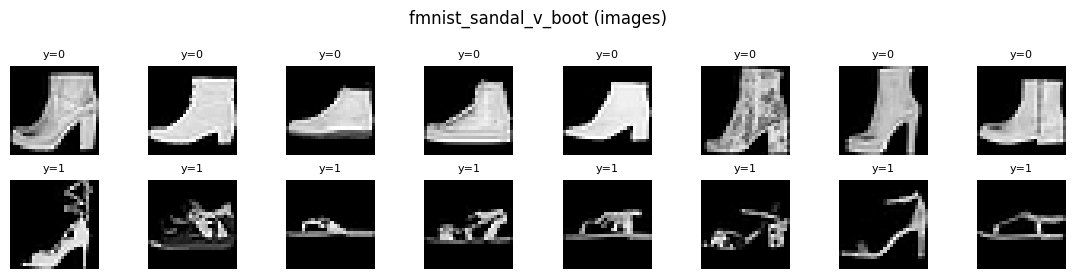


=== fmnist_shirt_v_coat ===
train: (12000, 784), classes: [0, 1], counts: {0: 6000, 1: 6000}


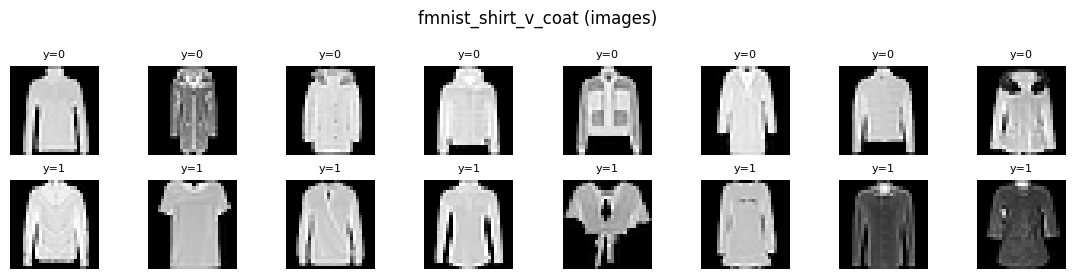


=== fmnist_tshirt_v_shirt ===
train: (12000, 784), classes: [0, 1], counts: {0: 6000, 1: 6000}


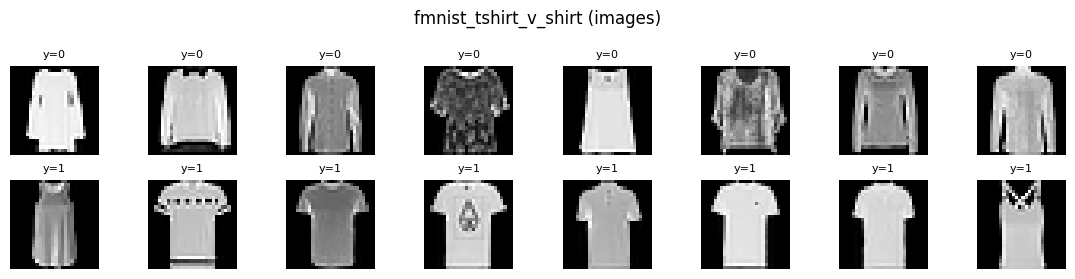


=== mnist_0v8 ===
train: (11774, 784), classes: [0, 1], counts: {0: 5851, 1: 5923}


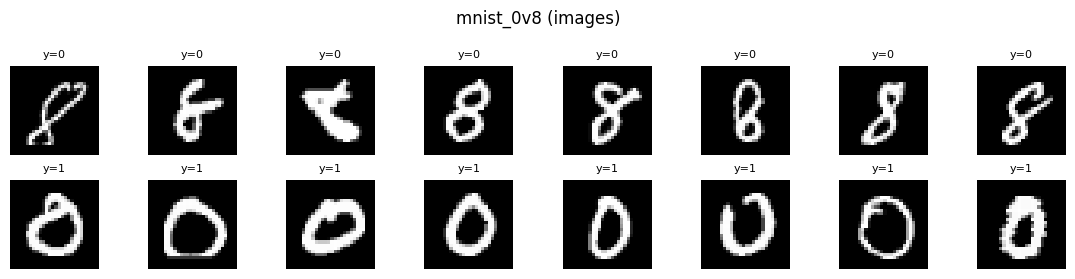


=== mnist_1v7 ===
train: (13007, 784), classes: [0, 1], counts: {0: 6265, 1: 6742}


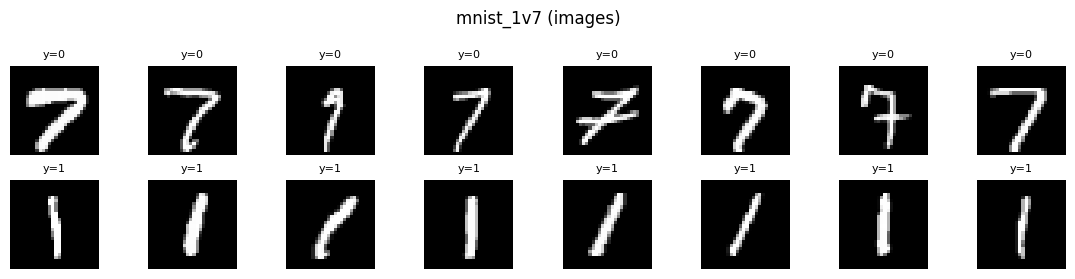


=== mnist_2v7 ===
train: (12223, 784), classes: [0, 1], counts: {0: 6265, 1: 5958}


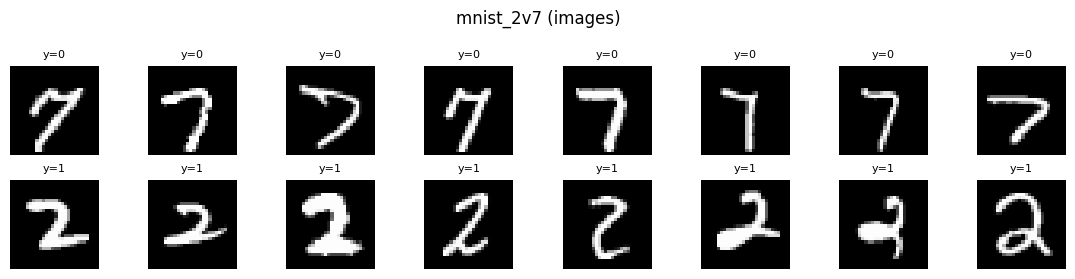


=== mnist_3v5 ===
train: (11552, 784), classes: [0, 1], counts: {0: 5421, 1: 6131}


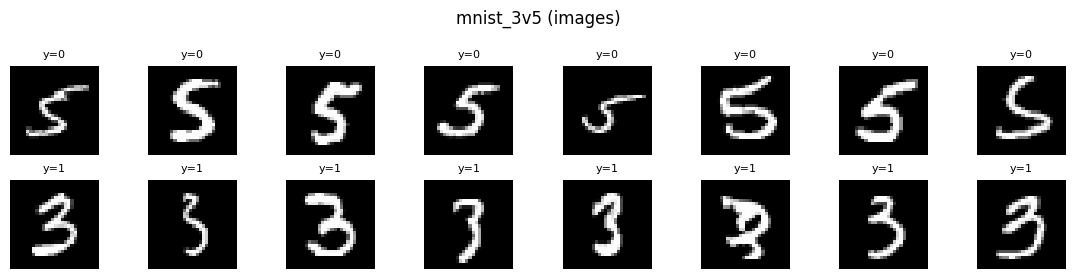


=== mnist_4v9 ===
train: (11791, 784), classes: [0, 1], counts: {0: 5949, 1: 5842}


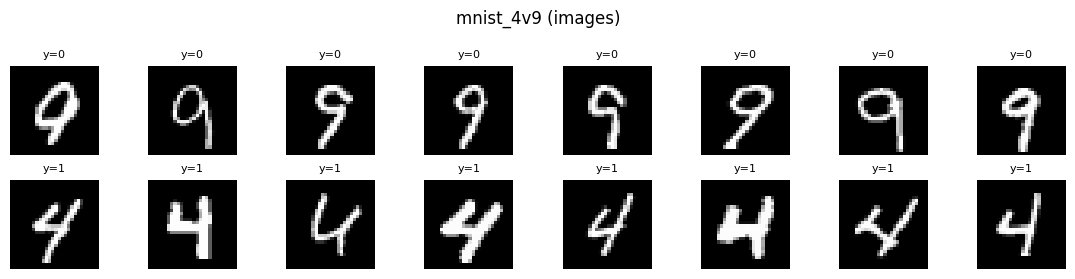


=== mnist_6v8 ===
train: (11769, 784), classes: [0, 1], counts: {0: 5851, 1: 5918}


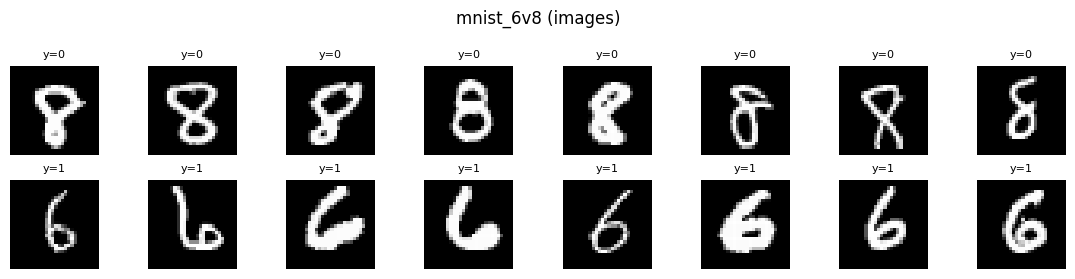


=== paper_syn_A_sin_bands_1k_each ===
train: (2000, 2), classes: [0, 1], counts: {0: 1000, 1: 1000}


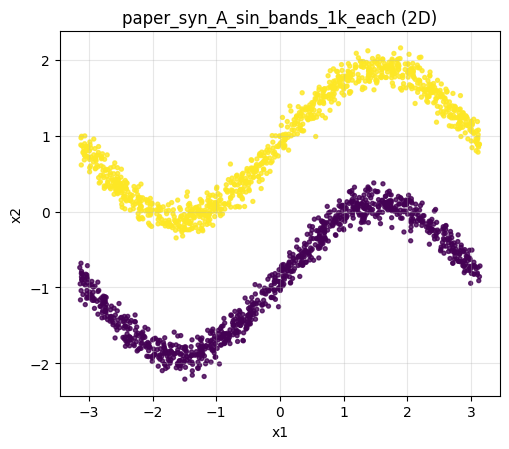


=== paper_syn_B_two_spirals_1k_each ===
train: (2000, 2), classes: [0, 1], counts: {0: 1000, 1: 1000}


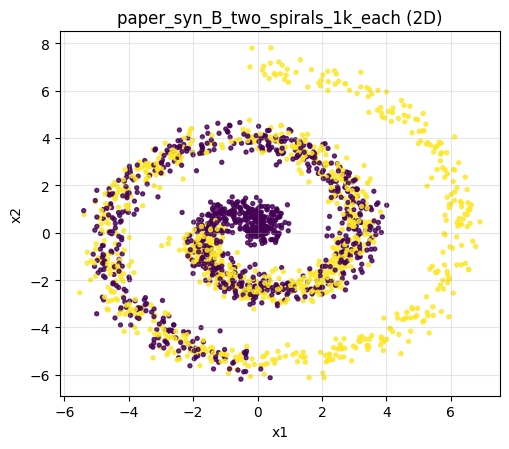


=== paper_syn_C_sine_surface_vs_plane_1k_each ===
train: (2000, 3), classes: [0, 1], counts: {0: 1000, 1: 1000}


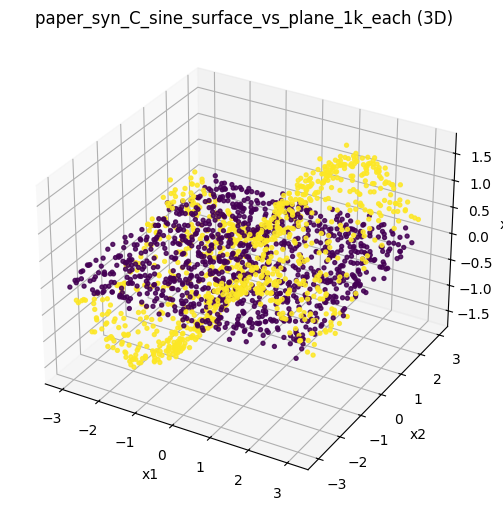


=== svhn_1v7 ===
train: (19456, 3072), classes: [0, 1], counts: {0: 5595, 1: 13861}


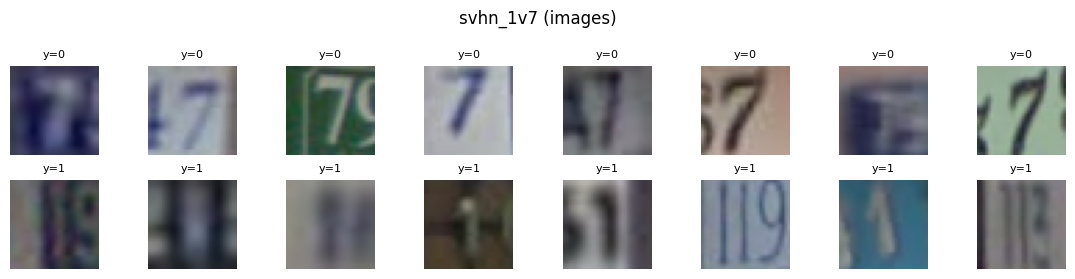


=== svhn_3v8 ===
train: (13542, 3072), classes: [0, 1], counts: {0: 5045, 1: 8497}


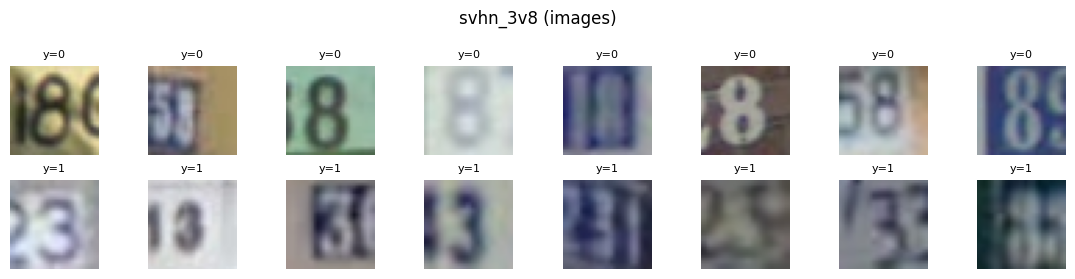


=== synthetic_A_moons_1k_each ===
train: (1000, 2), classes: [0, 1], counts: {0: 482, 1: 518}


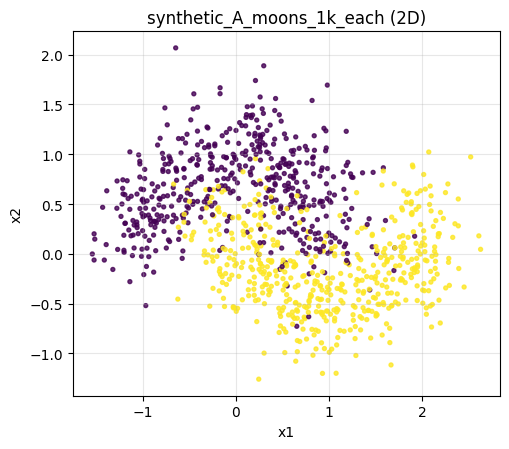


=== synthetic_A_moons_full10k ===
train: (10000, 2), classes: [0, 1], counts: {0: 5000, 1: 5000}


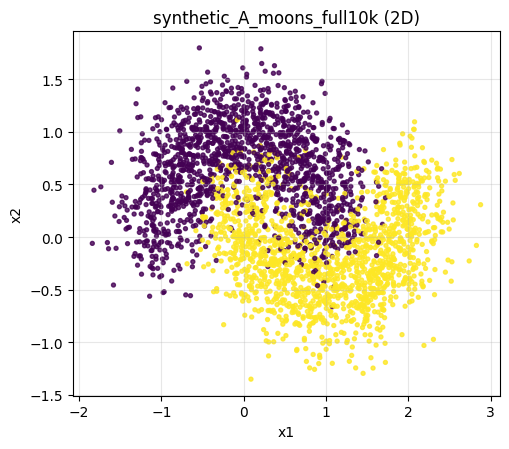


=== synthetic_B_circles_1k_each ===
train: (1000, 2), classes: [0, 1], counts: {0: 504, 1: 496}


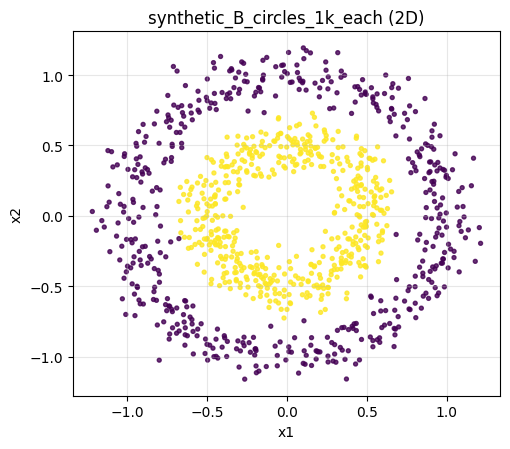


=== synthetic_C_blobs_1k_each ===
train: (1000, 2), classes: [0, 1], counts: {0: 517, 1: 483}


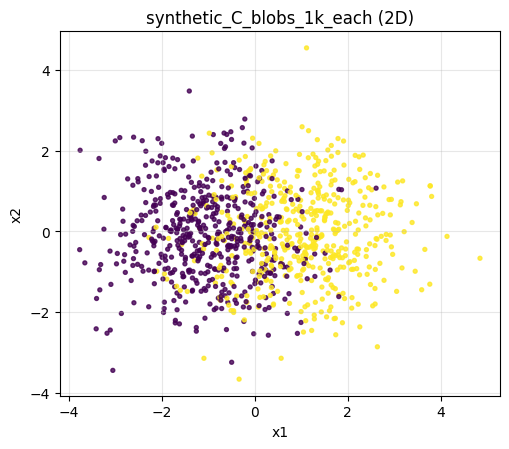

In [3]:
#@title Görselleştirme: data/*.npz içindeki TÜM datasetler için otomatik çizim
import os, math, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
MAX_PLOT_POINTS = 3000     # scatter için üst sınır (performans/okunurluk)
IMG_PER_CLASS = 8          # pano başına sınıf başına örnek
SEED = 123
RNG = np.random.default_rng(SEED)

# Yalnızca belirli datasetleri çizmek istersen isim (npz adı) ekle:
INCLUDE_ONLY = None  # örn: ["paper_syn_A_sin_bands_1k_each", "mnist_1v7"]

def _class_counts(y):
    vals, cnts = np.unique(y, return_counts=True)
    return dict(zip(vals.tolist(), cnts.tolist()))

def _subsample(X, y, max_n=MAX_PLOT_POINTS):
    n = len(X)
    if n <= max_n: 
        return X, y
    idx = RNG.permutation(n)[:max_n]
    return X[idx], y[idx]

def _grid_dims(n_panels):
    cols = min(8, n_panels)
    rows = math.ceil(n_panels / cols)
    return rows, cols

def _guess_image_shape(d):
    # Yaygın düzleştirilmiş görüntü boyutları için heuristik:
    if d == 28*28:          # MNIST / fMNIST
        return (28, 28, 1)
    if d == 32*32*3:        # CIFAR10 / SVHN
        return (32, 32, 3)
    if d == 32*32:          # muhtemel 32x32 grayscale
        return (32, 32, 1)
    return None

def _plot_images_grid(X, y, img_shape, title="", img_per_class=IMG_PER_CLASS):
    classes = sorted(np.unique(y).tolist())
    n_panels = len(classes) * img_per_class
    rows, cols = _grid_dims(n_panels)
    plt.figure(figsize=(cols*1.4, rows*1.4))
    k = 1
    for c in classes:
        idx = np.where(y==c)[0]
        if len(idx)==0: 
            continue
        take = min(img_per_class, len(idx))
        pick = RNG.choice(idx, size=take, replace=False)
        for i in pick:
            plt.subplot(rows, cols, k)
            img = X[i].reshape(img_shape)
            if img_shape[2] == 1:
                plt.imshow(img.squeeze(), cmap="gray")
            else:
                plt.imshow(img)
            plt.axis("off")
            plt.title(f"y={c}", fontsize=8)
            k += 1
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

def _scatter2d(X, y, title=""):
    Xs, ys = _subsample(X, y)
    plt.figure(figsize=(5.2, 4.6))
    plt.scatter(Xs[:,0], Xs[:,1], c=ys, s=8, alpha=0.8)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

def _scatter3d(X, y, title=""):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    Xs, ys = _subsample(X, y)
    fig = plt.figure(figsize=(6, 5.2))
    ax = fig.add_subplot(111, projection="3d")
    p = ax.scatter(Xs[:,0], Xs[:,1], Xs[:,2], c=ys, s=8, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("x3")
    plt.tight_layout(); plt.show()

def _pca2(X, n_components=2):
    from sklearn.decomposition import PCA
    return PCA(n_components=n_components).fit_transform(X)

def visualize_npz_dataset(npz_path: Path):
    name = npz_path.stem
    data = np.load(npz_path)
    Xtr, ytr = data["X_train"], data["y_train"]
    d = Xtr.shape[1] if Xtr.ndim == 2 else (np.prod(Xtr.shape[1:]) if Xtr.ndim>2 else 1)
    if Xtr.ndim > 2:  # güvenli tarafta ol
        Xtr = Xtr.reshape((Xtr.shape[0], -1))
        d = Xtr.shape[1]

    # Özet bilgi
    print(f"\n=== {name} ===")
    print(f"train: {Xtr.shape}, classes: {sorted(np.unique(ytr).tolist())}, counts: {_class_counts(ytr)}")
    
    # Görsel karar ağacı
    img_shape = _guess_image_shape(d)
    if d == 2:
        _scatter2d(Xtr, ytr, title=f"{name} (2D)")
    elif d == 3:
        _scatter3d(Xtr, ytr, title=f"{name} (3D)")
    elif img_shape is not None:
        _plot_images_grid(Xtr, ytr, img_shape, title=f"{name} (images)")
    else:
        # Genel durum: PCA(2D) + scatter (tek subsample çağrısı!)
        Xs, ys = _subsample(Xtr, ytr)
        Z = _pca2(Xs, n_components=2)
        plt.figure(figsize=(5.2,4.6))
        plt.scatter(Z[:,0], Z[:,1], c=ys, s=8, alpha=0.8)
        plt.title(f"{name} (PCA→2D)")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


# ==== Ana akış: tüm .npz dosyalarını çiz ====
npz_files = sorted([p for p in DATA_DIR.glob("*.npz")])
if INCLUDE_ONLY is not None:
    npz_files = [p for p in npz_files if p.stem in INCLUDE_ONLY]

if not npz_files:
    print("data/ içinde .npz bulunamadı. Önce veri hücresini çalıştır.")
else:
    for p in npz_files:
        try:
            visualize_npz_dataset(p)
        except Exception as e:
            print(f"[WARN] {p.name} çizilemedi: {e}")


In [24]:
#@title MLP factory (ReLU, RMSprop 1e-3, BCE) — NPZ'den otomatik input_dim (ROBUST + PAPER PRESETS)
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- width normalizasyonu: 'narrow'/'wide'/'bottleneck' | int | liste ----------
def _normalize_width(width, depth: int):
    # liste/tuple
    if isinstance(width, (list, tuple, np.ndarray)):
        w = [int(x) for x in width]
        if len(w) < depth:
            w = w + [w[-1]] * (depth - len(w))
        elif len(w) > depth:
            w = w[:depth]
        return w
    # tek sayı (veya sayıya çevrilebilir string)
    if isinstance(width, (int, np.integer)):
        return [int(width)] * depth
    if isinstance(width, str):
        w = width.lower().strip()
        if w == "narrow":
            return [25] * depth
        if w == "wide":
            return [50] * depth
        if w == "bottleneck":
            # Makale profilleri (5/11 için sabit), diğer derinlikler için ortayı daralt
            if depth == 5:
                return [50, 50, 25, 50, 50]
            if depth == 11:
                return [50, 50, 50, 50, 25, 50, 50, 50, 50, 50, 50]
            mid = max(0, depth // 2)
            arr = [50] * depth
            arr[mid] = 25
            return arr
        try:
            val = int(w)
            return [val] * depth
        except Exception:
            return [32] * depth
    # fallback
    return [32] * depth

def build_mlp(input_dim,
              width='narrow',
              depth=5,
              hidden_activation='relu',
              out_activation='sigmoid',
              optimizer='rmsprop',
              learning_rate=1e-3,
              use_batchnorm=False,
              dropout=0.0):
    """
    width: 'narrow'|'wide'|'bottleneck' veya int (64) ya da liste ([128,64,128])
    depth: gizli katman sayısı (çıktı hariç)
    """
    depth = int(depth)
    widths = _normalize_width(width, depth)

    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for units in widths:
        x = layers.Dense(int(units), activation=None)(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(hidden_activation)(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation=out_activation)(x)
    model = keras.Model(inputs, outputs)

    # optimizer seçimi (Keras 3 uyumlu)
    if isinstance(optimizer, str):
        opt_map = {
            "rmsprop": keras.optimizers.RMSprop,
            "adam":    keras.optimizers.Adam,
            "adamw":   getattr(keras.optimizers, "AdamW", keras.optimizers.Adam),
            "sgd":     keras.optimizers.SGD,
        }
        opt_cls = opt_map.get(optimizer.lower(), keras.optimizers.RMSprop)
        opt = opt_cls(learning_rate=float(learning_rate))
    else:
        opt = optimizer

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def _npz_input_dim(npz_path):
    """
    data/<name>.npz dosyasını okuyup X_train'in sütun sayısını döndürür.
    (Sentetik 2D/3D setler veya önceden flatten edilmiş görüntülerle uyumlu.)
    """
    with np.load(npz_path) as data:
        Xtr = data['X_train']
    Xtr = Xtr.reshape((Xtr.shape[0], -1))
    return Xtr.shape[1]

def build_mlp_for_npz(npz_path, width='narrow', depth=5,
                      hidden_activation='relu',
                      out_activation='sigmoid',
                      optimizer='rmsprop',
                      learning_rate=1e-3,
                      use_batchnorm=False,
                      dropout=0.0):
    input_dim = _npz_input_dim(npz_path)
    return build_mlp(input_dim,
                     width=width, depth=depth,
                     hidden_activation=hidden_activation,
                     out_activation=out_activation,
                     optimizer=optimizer,
                     learning_rate=learning_rate,
                     use_batchnorm=use_batchnorm,
                     dropout=dropout)

# ---------- Makale/Repo ile birebir uyumlu hazır ayarlar ----------
PAPER_WIDTHS = ('narrow', 'wide', 'bottleneck')  # 25, 50, 50-25-50...
PAPER_DEPTHS = (5, 11)
PAPER_OPTS   = dict(
    epochs=50,
    batch_size=32,
    standardize=True,
    hidden_activation='relu',
    out_activation='sigmoid',
    optimizer='rmsprop',
    learning_rate=1e-3,
)


In [25]:
# --- kısa smoke test (yorumdan çıkarıp herhangi bir NPZ ile deneyebilirsin) ---
m = build_mlp_for_npz("data/paper_syn_A_sin_bands_1k_each.npz", width='bottleneck', depth=5)
m.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,876 (30.77 KB)

 Trainable params: 7,876 (30.77 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# === RUN & LOG UTILITIES (fixed: safe width handling) ===
from pathlib import Path
import json, time, datetime
import numpy as np

LOGS_DIR = Path("logs"); LOGS_DIR.mkdir(exist_ok=True)

# --- width helpers ---
def width_spec(width):
    """
    Modeli kurarken kullanabileceğin sayısal genişlik gösterimi.
    'narrow' -> 25, 'wide' -> 50, 'bottleneck' -> [50,25,50]
    Zaten int verilmişse aynen döner.
    """
    if isinstance(width, (list, tuple, np.ndarray)):
        return list(width)
    if isinstance(width, (int, np.integer)):
        return int(width)
    if isinstance(width, str):
        w = width.lower().strip()
        if w == "narrow":
            return 25
        if w == "wide":
            return 50
        if w == "bottleneck":
            return [50, 25, 50]
        # başka bir string ise aynen bırak
        return w
    return width

def width_meta(width):
    """
    JSON'a yazılacak güvenli değer: int | list | string
    """
    spec = width_spec(width)
    if isinstance(spec, (list, tuple, np.ndarray)):
        return list(map(int, spec)) if all(isinstance(x, (int, np.integer)) for x in spec) else list(spec)
    if isinstance(spec, (int, np.integer)):
        return int(spec)
    return str(spec)

def width_slug(width):
    """
    Dosya adı/etiket için kısa gösterim.
    """
    spec = width_spec(width)
    if isinstance(spec, (int, np.integer)):
        return f"w{int(spec)}"
    if isinstance(spec, (list, tuple, np.ndarray)):
        return "bottleneck"
    if isinstance(spec, str):
        return spec
    return "w?"

def _now_iso():
    return datetime.datetime.now().isoformat(timespec="seconds")

# --------------------------------------------------------
# Not: Bu fonksiyon, senin önceki hücrendeki run_one imzasıyla
# birebir uyumludur (params ve dönüşler aynı tutuldu).
def run_one(dataset_npz,
            width,
            depth,
            epochs=20,
            batch_size=256,
            seeds=0,
            standardize=True,
            save_meta=True):
    """
    Tek koşu: veriyi yükle -> (ops.) standardize -> modeli kur/eğit -> değerlendir ->
    (ops.) embeddingleri ve meta’yı kaydet.
    Dönüş: acc, base, layers (layer adları listesi)
    """
    # ---- veri ----
    d = np.load(dataset_npz)
    Xtr, ytr = d["X_train"].astype("float32"), d["y_train"].astype("float32")
    Xte, yte = d["X_test"].astype("float32"),  d["y_test"].astype("float32")
    # BCE için (N,1) ve {0,1} float
    ytr = ytr.reshape(-1, 1)
    yte = yte.reshape(-1, 1)

    # ---- standardizasyon (train ort/standart sapma) ----
    if standardize:
        mu = Xtr.mean(axis=0, keepdims=True)
        sd = Xtr.std(axis=0, keepdims=True) + 1e-8
        Xtr = (Xtr - mu) / sd
        Xte = (Xte - mu) / sd
    else:
        mu = np.zeros((1, Xtr.shape[1]), dtype=np.float32)
        sd = np.ones((1, Xtr.shape[1]),  dtype=np.float32)

    # ---- tohum ve model ----
    tf.keras.utils.set_random_seed(int(seeds))
    input_dim = Xtr.shape[1]
    model = build_mlp(input_dim, width=width, depth=depth)  # senin build_mlp()

    # ---- eğitim/eval ----
    _ = model.fit(Xtr, ytr,
                  validation_data=(Xte, yte),
                  epochs=int(epochs),
                  batch_size=int(batch_size),
                  verbose=0)
    _, acc = model.evaluate(Xte, yte, verbose=0)
    acc = float(acc)

    # ---- base / run_id ----
    ds_name = Path(dataset_npz).with_suffix("").name
    base = f"{ds_name}__{width_slug(width)}__d{int(depth)}__s{int(seeds)}"

    # ---- ara katman embeddingleri (output katmanı hariç) ----
    emb_dir = Path("embeddings") / base
    emb_dir.mkdir(parents=True, exist_ok=True)
    dense_layers = [lyr for lyr in model.layers if isinstance(lyr, layers.Dense)]
    # son (çıktı) katmanı dahil etme:
    dense_layers = dense_layers[:-1] if len(dense_layers) > 1 else dense_layers
    layer_names = []
    for lyr in dense_layers:
        feat_model = keras.Model(model.input, lyr.output)
        Z = feat_model.predict(Xte, verbose=0)  # (N, d_l)
        np.save(emb_dir / f"{lyr.name}.npy", Z.astype("float32"))
        layer_names.append(lyr.name)
    # test etiketlerini de kaydet
    np.save(emb_dir / "y_test.npy", yte.astype("float32"))

    # ---- meta/log ----
    if save_meta:
        LOGS_DIR.mkdir(parents=True, exist_ok=True)
        meta = {
            "dataset": str(dataset_npz),
            "width":  width_meta(width),   # int | list | string (güvenli)
            "depth":  int(depth),
            "seed":   int(seeds),
            "epochs": int(epochs),
            "batch_size": int(batch_size),
            "standardize": bool(standardize),
            "acc": acc,
            "layer_names": layer_names,
        }
        # standardizasyon istiyorsan saklamak isteyebilirsin:
        np.save(emb_dir / "mu.npy", mu.astype("float32"))
        np.save(emb_dir / "sd.npy", sd.astype("float32"))
        with open(LOGS_DIR / f"{base}.json", "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)

    print(f"[OK] {base}  acc={acc:.4f}")
    return acc, base, layer_names

# --------------------------------------------------------
def run_cycle(widths=("narrow","wide","bottleneck"),
              depths=(3, 11),
              seeds=(0,),
              include_only=None,
              epochs=20,
              batch_size=256,
              standardize=True):
    """
    Birden çok veri seti/genişlik/derinlik/tohum kombinasyonunu çalıştırır.
    """
    # Veri seti listesi: dışarıdan 'include_only' gelmişse onu kullan.
    datasets = include_only if include_only is not None else [
        # örnek isimler; sende zaten hazırlanmış liste/üretim var
        "paper_syn_A_sin_bands_1k_each",
        "paper_syn_B_two_spirals_1k_each",
        "paper_syn_C_sine_surface_vs_plane_1k_each",
    ]
    # .npz yolunu kur (senin dizin yapına göre)
    ds_paths = [Path("data") / f"{ds}.npz" for ds in datasets]

    results = []
    for ds in ds_paths:
        for w in widths:
            for d in depths:
                for s in seeds:
                    acc, base, layers = run_one(
                        ds, w, d,
                        epochs=epochs,
                        batch_size=batch_size,
                        seeds=s,
                        standardize=standardize,
                        save_meta=True
                    )
                    results.append((ds, w, d, s, acc, base))
    return results


In [27]:
# --- PAPER SYNTHETICS (A/B/C) ---
run_cycle(widths=('narrow',), depths=(3,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["paper_syn_A_sin_bands_1k_each"])

run_cycle(widths=('narrow',), depths=(3,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["paper_syn_B_two_spirals_1k_each"])

run_cycle(widths=('narrow',), depths=(3,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["paper_syn_C_sine_surface_vs_plane_1k_each"])


[OK] paper_syn_A_sin_bands_1k_each__w25__d3__s0  acc=0.9990
[OK] paper_syn_B_two_spirals_1k_each__w25__d3__s0  acc=0.6485
[OK] paper_syn_C_sine_surface_vs_plane_1k_each__w25__d3__s0  acc=0.9115


[(WindowsPath('data/paper_syn_C_sine_surface_vs_plane_1k_each.npz'),
  'narrow',
  3,
  0,
  0.9114999771118164,
  'paper_syn_C_sine_surface_vs_plane_1k_each__w25__d3__s0')]

In [28]:
# --- MNIST (çoklu ikili) ---
run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["mnist_1v7"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["mnist_6v8"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["mnist_0v8","mnist_2v7","mnist_3v5","mnist_4v9"])


[OK] mnist_1v7__w64__d3__s0  acc=0.9954
[OK] mnist_6v8__w64__d3__s0  acc=0.9943
[OK] mnist_0v8__w64__d3__s0  acc=0.9933
[OK] mnist_2v7__w64__d3__s0  acc=0.9908
[OK] mnist_3v5__w64__d3__s0  acc=0.9869
[OK] mnist_4v9__w64__d3__s0  acc=0.9869


[(WindowsPath('data/mnist_0v8.npz'),
  64,
  3,
  0,
  0.9933469891548157,
  'mnist_0v8__w64__d3__s0'),
 (WindowsPath('data/mnist_2v7.npz'),
  64,
  3,
  0,
  0.9907767176628113,
  'mnist_2v7__w64__d3__s0'),
 (WindowsPath('data/mnist_3v5.npz'),
  64,
  3,
  0,
  0.9868559241294861,
  'mnist_3v5__w64__d3__s0'),
 (WindowsPath('data/mnist_4v9.npz'),
  64,
  3,
  0,
  0.9869412183761597,
  'mnist_4v9__w64__d3__s0')]

In [29]:
# --- Fashion-MNIST (çoklu ikili) ---
run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["fmnist_sandal_v_boot"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["fmnist_shirt_v_coat","fmnist_tshirt_v_shirt"])


[OK] fmnist_sandal_v_boot__w64__d3__s0  acc=0.9860
[OK] fmnist_shirt_v_coat__w64__d3__s0  acc=0.9100
[OK] fmnist_tshirt_v_shirt__w64__d3__s0  acc=0.8385


[(WindowsPath('data/fmnist_shirt_v_coat.npz'),
  64,
  3,
  0,
  0.9100000262260437,
  'fmnist_shirt_v_coat__w64__d3__s0'),
 (WindowsPath('data/fmnist_tshirt_v_shirt.npz'),
  64,
  3,
  0,
  0.8385000228881836,
  'fmnist_tshirt_v_shirt__w64__d3__s0')]

In [30]:
# --- CIFAR-10 (iki ikili) ---
run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["cifar10_car_v_truck"])

run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["cifar10_cat_v_dog"])


[OK] cifar10_car_v_truck__w128__d5__s0  acc=0.7590
[OK] cifar10_cat_v_dog__w128__d5__s0  acc=0.6330


[(WindowsPath('data/cifar10_cat_v_dog.npz'),
  128,
  5,
  0,
  0.6330000162124634,
  'cifar10_cat_v_dog__w128__d5__s0')]

In [31]:
# --- SVHN (iki ikili) ---
# Not: SVHN büyük; yine de tek seed + 20 epoch kullanıyoruz.
run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=512, include_only=["svhn_1v7"])

run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=512, include_only=["svhn_3v8"])


[OK] svhn_1v7__w128__d5__s0  acc=0.9178
[OK] svhn_3v8__w128__d5__s0  acc=0.8882


[(WindowsPath('data/svhn_3v8.npz'),
  128,
  5,
  0,
  0.8881549835205078,
  'svhn_3v8__w128__d5__s0')]

,dataset,width,depth,seed,epochs,batch_size,standardize,test_acc,rho,z,run_id
4,fmnist_tshirt_v_shirt,64,3,0,15,256,True,0.838500,NaN,NaN,fmnist_tshirt_v_shirt__w64__d3__s0
5,mnist_0v8,64,3,0,15,256,True,0.993347,NaN,NaN,mnist_0v8__w64__d3__s0
6,mnist_1v7,64,3,0,15,256,True,0.995377,NaN,NaN,mnist_1v7__w64__d3__s0
7,mnist_2v7,64,3,0,15,256,True,0.990777,NaN,NaN,mnist_2v7__w64__d3__s0
8,mnist_3v5,64,3,0,15,256,True,0.986856,NaN,NaN,mnist_3v5__w64__d3__s0
9,mnist_4v9,64,3,0,15,256,True,0.986941,NaN,NaN,mnist_4v9__w64__d3__s0
10,mnist_6v8,64,3,0,15,256,True,0.994306,NaN,NaN,mnist_6v8__w64__d3__s0
11,paper_syn_A_sin_bands_1k_each,25,3,0,20,256,True,0.999000,NaN,NaN,paper_syn_A_sin_bands_1k_each__w25__d3__s0
12,paper_syn_B_two_spirals_1k_each,25,3,0,20,256,True,0.648500,NaN,NaN,paper_syn_B_two_spirals_1k_each__w25__d3__s0
13,paper_syn_C_sine_surface_vs_plane_1k_each,25,3,0,20,256,True,0.911500,NaN,NaN,paper_syn_C_sine_surface_vs_plane_1k_each__w25...


rho kolonu yok/boş → sadece accuracy dağılımı.


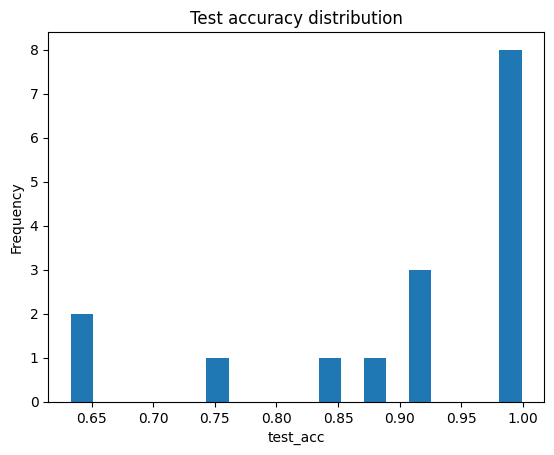

emb_dir -> embeddings\svhn_3v8__w128__d5__s0


In [33]:
#@title Son Koşular Tablosu + Güvenli Yükleyici (CSV yoksa JSON/ricci_summary'dan toparla)
from pathlib import Path
import pandas as pd, numpy as np, json
from IPython.display import display

LOGS_DIR = Path("logs")
EMB_DIR  = Path("embeddings")

def _load_from_run_cycle_csv():
    p = LOGS_DIR / "run_cycle_results.csv"
    return pd.read_csv(p) if p.exists() else None

def _load_from_ricci_summary():
    p = Path("ricci_summary.csv")
    return pd.read_csv(p) if p.exists() else None

def _load_from_json_meta():
    rows = []
    if not LOGS_DIR.exists(): return None
    for jf in sorted(LOGS_DIR.glob("*.json")):
        try:
            with open(jf, "r", encoding="utf-8") as f:
                m = json.load(f)
            base = jf.stem
            rows.append({
                "run_id": base,
                "dataset": Path(m.get("dataset","")).stem,
                "width":   m.get("width"),
                "depth":   m.get("depth"),
                "seed":    m.get("seed"),
                "epochs":  m.get("epochs"),
                "batch_size": m.get("batch_size"),
                "standardize": m.get("standardize"),
                "test_acc": m.get("acc"),
                "rho": m.get("rho", np.nan),
                "z":   m.get("z",   np.nan),
            })
        except Exception as e:
            print(f"[skip] {jf.name}: {e}")
    return pd.DataFrame(rows) if rows else None

def load_runs_table():
    for loader in (_load_from_run_cycle_csv, _load_from_ricci_summary, _load_from_json_meta):
        df = loader()
        if df is not None and len(df)>0:
            want = ["dataset","width","depth","seed","epochs","batch_size",
                    "standardize","test_acc","rho","z","run_id"]
            for c in want:
                if c not in df.columns: df[c] = np.nan
            df = df[want]
            for c in ["depth","seed","epochs","batch_size"]:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            return df.sort_values(["dataset","depth","seed"], na_position="last")
    return pd.DataFrame(columns=["dataset","width","depth","seed","epochs","batch_size",
                                 "standardize","test_acc","rho","z","run_id"])

def scatter_rho_vs_acc(df, by="dataset"):
    import matplotlib.pyplot as plt
    if "rho" not in df.columns or df["rho"].isna().all():
        print("rho kolonu yok/boş → sadece accuracy dağılımı.")
        ax = df["test_acc"].plot(kind="hist", bins=20)
        ax.set_xlabel("test_acc"); ax.set_title("Test accuracy distribution")
        plt.show(); return
    if by and by in df.columns:
        for key, g in df.groupby(by):
            plt.figure()
            plt.scatter(g["rho"], g["test_acc"])
            plt.xlabel("rho"); plt.ylabel("test_acc"); plt.title(f"rho vs acc — {by}={key}")
            plt.show()
    else:
        plt.scatter(df["rho"], df["test_acc"]); plt.xlabel("rho"); plt.ylabel("test_acc"); plt.title("rho vs acc (all)"); plt.show()

# 1) Tabloyu yükle
df = load_runs_table()
if len(df)==0:
    raise FileNotFoundError("Koşu kaydı bulunamadı. Önce run_cycle çalıştırıp logs/*.json veya ricci_summary.csv üret.")

display(df.tail(12))

# 2) rho–acc (varsa)
scatter_rho_vs_acc(df, by="dataset")

# 3) Son koşunun embedding klasörü
last_run_id = str(df.iloc[-1]["run_id"])
emb_dir = EMB_DIR / last_run_id
print("emb_dir ->", emb_dir)
# Örnek:
# Ric_list = compute_total_forman_ricci_over_layers(emb_dir, k=15)
# g_list   = compute_total_geodesic_over_layers(emb_dir, k=15)
# plot_trends_over_layers(Ric_list, g_list)


In [34]:
#@title Ricci metrics (fast): ignore last layer, sampling, giant component [UPDATED]
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path, connected_components
from scipy.stats import pearsonr
from pathlib import Path
import re

def _bin_adjacency(A):
    B = (A > 0).astype(np.int8).tocsr()
    return B.maximum(B.T)

def _largest_component_mask(B):
    ncomp, labels = connected_components(csgraph=B, directed=False, return_labels=True)
    if ncomp == 1:
        return np.ones(B.shape[0], dtype=bool), 1.0
    counts = np.bincount(labels)
    giant = np.argmax(counts)
    mask = (labels == giant)
    ratio = counts[giant] / B.shape[0]
    return mask, ratio

def _forman_ricci_total(B):
    deg = np.ravel(B.sum(axis=1)).astype(np.int64)
    rows, cols = B.nonzero()
    mask = rows < cols
    ri = rows[mask]; rj = cols[mask]
    return int(np.sum(4 - deg[ri] - deg[rj]))

def layerwise_global_metrics_fast(
    emb_dir: Path,
    layer_names,
    k_values,
    ignore_last_layer: bool = True,
    sample_size: int | None = None,
    min_component_ratio: float = 0.99,
    rng_seed: int = 0,
    return_connectivity: bool = True,
):
    """
    Her k için:
      - Ric_l toplamı (Forman) ve g_l toplam geodezikten r = corr(eta_l, Ric_l) ve z hesaplar.
      - İsteğe bağlı: connectivity ısı haritası için (k,l) bazlı giant component ratio döndürür.
    """
    use_layers = layer_names[:-1] if ignore_last_layer and len(layer_names) > 1 else layer_names[:]
    if len(use_layers) < 2:
        return [(k, np.nan, np.nan, len(use_layers), False) for k in k_values], None

    y = np.load(emb_dir / "y_test.npy")
    n_total = y.shape[0]
    rng = np.random.default_rng(rng_seed)

    # örnekleme (node subset)
    if sample_size is not None and sample_size < n_total:
        idx = np.sort(rng.choice(n_total, size=sample_size, replace=False))
    else:
        idx = np.arange(n_total)

    results = []
    conn_map = {}  # k -> [ratio per layer]
    for k in k_values:
        Ric, gvals = [], []
        valid = True
        ratios = []

        for lname in use_layers:
            Z = np.load(emb_dir / f"{lname}.npy")[idx]  # (m, d_l)
            A = kneighbors_graph(Z, n_neighbors=k, mode='distance', include_self=False, n_jobs=-1)
            B = _bin_adjacency(A)

            # dev bileşen toleransı
            mask, ratio = _largest_component_mask(B)
            ratios.append(float(ratio))
            if ratio < min_component_ratio:
                valid = False
                # devam etmeden bu k'yı invalid işaretliyoruz
                break

            if not mask.all():
                sel = np.where(mask)[0]
                B = B[sel][:, sel]

            # Ricci toplamı (Forman)
            ric_total = _forman_ricci_total(B)
            Ric.append(float(ric_total))

            # geodezik toplamı (unweighted BFS)
            D = shortest_path(B, directed=False, unweighted=True)
            if np.isinf(D).any():
                valid = False
                break
            gvals.append(float(np.sum(D)))

        if return_connectivity:
            conn_map[k] = ratios if len(ratios)==len(use_layers) else [np.nan]*len(use_layers)

        if not valid:
            results.append((k, np.nan, np.nan, len(use_layers), False))
            continue

        Ric = np.asarray(Ric, dtype=float)
        gvals = np.asarray(gvals, dtype=float)
        eta = gvals[1:] - gvals[:-1]

        # sabit vektörler NaN üretmesin diye kontrol
        if np.allclose(eta, eta[0]) or np.allclose(Ric[:-1], Ric[:-1][0]):
            results.append((k, np.nan, np.nan, len(use_layers), False))
            continue

        r, _ = pearsonr(eta, Ric[:-1])
        # Fisher z: küçük L'de dikkat
        denom = max(len(use_layers) - 4, 1)
        z = np.arctanh(np.clip(r, -0.999999, 0.999999)) / np.sqrt(denom)
        results.append((k, float(r), float(z), len(use_layers), True))

    return results, conn_map if return_connectivity else None


def _infer_dataset_mode_from_runid(run_id: str) -> str:
    """
    run_id'dan sentetik/real ipucu çıkar.
    - 'paper_syn', 'synthetic_' gibi önekler → 'synthetic'
    - aksi → 'real'
    """
    rid = run_id.lower()
    if re.search(r"(paper_syn|synthetic_|syn_|_syn_|moons|spiral|circle|blobs)", rid):
        return "synthetic"
    return "real"


def auto_k_sweep_fast(
    run_id,
    layer_names,
    mode: str | None = None,
    sample_size=None,
    min_component_ratio=0.99,
    rng_seed=0,
    return_connectivity: bool = True,
):
    """
    mode=None ise run_id'a bakarak 'synthetic'/'real' belirlenir.
    - synthetic: daha küçük k'ler de denenir (küçük N ve “daha kıvrımlı” graf yapıları için).
    - real: daha geniş k ızgarası.
    """
    if mode is None:
        mode = _infer_dataset_mode_from_runid(run_id)

    if mode == 'synthetic':
        k_values = [4,5,6,7,9,10,12,15,18,20,30,50,90]
    else:
        k_values = [10,20,30,50,90,120,150,200,250,350]

    emb_dir = Path("embeddings") / run_id
    res, conn_map = layerwise_global_metrics_fast(
        emb_dir, layer_names, k_values,
        ignore_last_layer=True,            # <-- kritik
        sample_size=sample_size,           # örn. 800
        min_component_ratio=min_component_ratio,
        rng_seed=rng_seed,
        return_connectivity=return_connectivity,
    )
    # en negatif r en başa
    good = [r for r in res if r[-1] and not np.isnan(r[1])]
    best = sorted(good, key=lambda x: x[1])[0] if good else None
    return res, best, k_values, conn_map


In [36]:
#@title k-sweep (auto) — run_id ve layer_names otomatik tespit + güvenli yürütme
from pathlib import Path
import json

LOGS_DIR = Path("logs")
EMB_DIR  = Path("embeddings")

# 1) id1 (run_id) ve ln1 (layer_names) otomatik bul
def _auto_pick_last_run():
    jfs = sorted(LOGS_DIR.glob("*.json"), key=lambda p: p.stat().st_mtime)
    if not jfs:
        raise FileNotFoundError("logs/*.json bulunamadı. Önce run_cycle çalıştırın.")
    jf = jfs[-1]
    run_id = jf.stem
    # meta'dan layer_names dene
    try:
        with open(jf, "r", encoding="utf-8") as f:
            meta = json.load(f)
        layer_names = meta.get("layer_names")
    except Exception:
        layer_names = None
    # embeddings klasöründen çıkar (gerekirse)
    if not layer_names:
        epath = EMB_DIR / run_id
        if not epath.exists():
            raise FileNotFoundError(f"embeddings/{run_id} yok. Embedding üretimi yapılmalı.")
        layer_names = [p.stem for p in sorted(epath.glob("*.npy"))
                       if p.stem not in ("y_test","mu","sd")]
    return run_id, layer_names

try:
    id1  # var mı?
    ln1
except NameError:
    id1, ln1 = _auto_pick_last_run()

# 2) k-sweep çalıştır
# Not: fonksiyon imzası: auto_k_sweep_fast(run_id, layer_names, mode=..., sample_size=..., rng_seed=...)
res, best, ks, conn = auto_k_sweep_fast(id1, ln1, mode='synthetic', sample_size=None, rng_seed=0)

# 3) çıktı
print("k, rho, z, L, connected")
for t in res:
    print(t)
print("BEST:", best)

# 4) (opsiyonel) bağlı bileşen ısı haritası
try:
    connectivity_heatmap(conn)
except NameError:
    print("connectivity_heatmap tanımlı değil; grafiği atlıyorum.")


k, rho, z, L, connected
(4, 0.997732601433859, 3.39056747445748, 4, True)
(5, 0.9990706021824709, 3.836828031609622, 4, True)
(6, 0.9969395123077545, 3.2403983819305084, 4, True)
(7, 0.996418373321994, 3.161646482117524, 4, True)
(9, 0.9976906720892984, 3.381395296998371, 4, True)
(10, 0.9979129029644837, 3.4320421219590025, 4, True)
(12, 0.9974196602899852, 3.325845197943656, 4, True)
(15, 0.9944840110678441, 2.9452448506855053, 4, True)
(18, 0.983319797923649, 2.3891524367628008, 4, True)
(20, 0.969066857873666, 2.0767434317307862, 4, True)
(30, 0.9769855717595112, 2.226603595521431, 4, True)
(50, 0.9774768102577412, 2.2375157695569996, 4, True)
(90, 0.9844307655958134, 2.423895285305731, 4, True)
BEST: (20, 0.969066857873666, 2.0767434317307862, 4, True)
connectivity_heatmap tanımlı değil; grafiği atlıyorum.


In [37]:
#@title ProgressBoard yardımcıları (reset-safe, grid-aware)
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Iterable
import time, pandas as pd, numpy as np
from IPython.display import clear_output, display
import math
from itertools import product

@dataclass
class ProgressBoard:
    columns: List[str]
    title: str = "Progress"
    rows: List[Dict[str, Any]] = field(default_factory=list)
    total: Optional[int] = None
    t0: float = field(default_factory=time.time)
    auto_cols: bool = True            # yeni alanları kolonlara otomatik ekle
    sort_pref: List[str] = field(default_factory=lambda: ["dataset","mode","width","depth","k","seed","elapsed_s"])
    _last_render: float = field(default_factory=lambda: 0.0)
    _render_min_interval: float = 0.2 # saniye; çok hızlı add() spam’ında ekranı yormasın

    # --- API ---
    def set_total(self, total: int):
        self.total = int(total)
        self.render(force=True)

    def bump_total(self, delta: int):
        self.total = (self.total or 0) + int(delta)
        self.render(force=True)

    def set_total_from_grid(self,
                            datasets: Iterable[str],
                            widths: Iterable[Any],
                            depths: Iterable[Any],
                            seeds: Iterable[int],
                            ks: Optional[Iterable[int]] = None,
                            repeats: int = 1):
        """
        grid toplam adımı hesaplar:
          |datasets| × |widths| × |depths| × |seeds| × (|ks| veya 1) × repeats
        """
        n = len(list(datasets)) * len(list(widths)) * len(list(depths)) * len(list(seeds))
        n *= (len(list(ks)) if ks is not None else 1)
        n *= int(repeats)
        self.set_total(n)

    def add(self, **kwargs):
        """
        Örn:
        add(dataset="paper_syn_A_sin_bands_1k_each", mode="real", width="narrow", depth=7,
            k=25, seed=0, test_acc=0.912, rho=-0.63, z=-0.71, connected_all_layers=True,
            elapsed_s=123.4, run_id="...") 
        """
        self.rows.append(kwargs)
        self.render()

    # --- İç ---
    def _compute_eta(self, done: int, elapsed: float):
        if not self.total or done == 0: 
            return None
        rate = done / max(elapsed, 1e-9)
        remain = self.total - done
        eta_s = remain / max(rate, 1e-9)
        return eta_s

    def render(self, force: bool=False):
        now = time.time()
        if not force and (now - self._last_render) < self._render_min_interval:
            return
        self._last_render = now

        clear_output(wait=True)

        # DataFrame’e dök
        df = pd.DataFrame(self.rows)

        # kolonları tamamla / yeni metrikleri ekle
        if self.auto_cols and len(df):
            unseen = [c for c in df.columns if c not in self.columns]
            if unseen:
                self.columns += unseen

        # eksik kolonları doldur
        for c in self.columns:
            if c not in df.columns:
                df[c] = np.nan

        # sıralama
        sort_cols = [c for c in self.sort_pref if c in df.columns]
        if sort_cols:
            with pd.option_context('mode.use_inf_as_na', True):
                df = df.sort_values(by=sort_cols, na_position='last', kind="mergesort")

        # sadece tanımlı kolonları göster
        df = df[self.columns]

        # başlık
        print(f"=== {self.title} ===")
        display(df)

        # durum satırı
        done = len(self.rows)
        elapsed = time.time() - self.t0
        if self.total:
            pct = 100.0 * done / max(self.total, 1)
            eta_s = self._compute_eta(done, elapsed)
            eta_str = f" | ETA ~{_fmt_duration(eta_s)}" if eta_s is not None and eta_s < 9e6 else ""
            print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {_fmt_duration(elapsed)}{eta_str}")
        else:
            print(f"[{self.title}] steps={done} | elapsed {_fmt_duration(elapsed)}")

        # küçük özet: dataset bazlı tamamlanan sayılar
        if len(df) and "dataset" in df.columns:
            cnt = df["dataset"].value_counts().sort_index()
            with pd.option_context('display.max_rows', 200, 'display.width', 120):
                print("\nCompleted per dataset:")
                display(cnt.to_frame("done"))

def timed_step(fn, *args, **kwargs):
    t0 = time.time()
    out = fn(*args, **kwargs)
    return out, round(time.time()-t0, 1)

def _fmt_duration(sec: float) -> str:
    if sec is None: return "?"
    sec = float(sec)
    if sec < 60: return f"{sec:.1f}s"
    m, s = divmod(int(round(sec)), 60)
    if m < 60: return f"{m}m{s:02d}s"
    h, m = divmod(m, 60)
    return f"{h}h{m:02d}m"

print("ProgressBoard (grid-aware) loaded.")


ProgressBoard (grid-aware) loaded.


In [40]:
#@title Grid runner (FAST) + Canlı İlerleme Paneli ✅ + Ayrı Log Dosyaları (session & dataset)
from pathlib import Path
import time, pandas as pd, numpy as np
from IPython.display import clear_output, display
from datetime import datetime

# ---------- Yol/klasörler ----------
LOGS_DIR = Path("logs")
SESS_DIR = LOGS_DIR / "sessions"
DS_DIR   = LOGS_DIR / "by_dataset"
for p in (LOGS_DIR, SESS_DIR, DS_DIR):
    p.mkdir(parents=True, exist_ok=True)

SESSION_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
SESSION_CSV = SESS_DIR / f"session_{SESSION_TAG}.csv"

# ---------- Dataset listesi ----------
DATASETS = [
  # ---- Paper synthetic A/B/C (NEW) ----
  ("data/paper_syn_A_sin_bands_1k_each.npz", "synthetic"),
  ("data/paper_syn_B_two_spirals_1k_each.npz", "synthetic"),
  ("data/paper_syn_C_sine_surface_vs_plane_1k_each.npz", "synthetic"),

  # ---- Existing synthetic ----
  ("data/synthetic_A_moons_1k_each.npz", "synthetic"),
  ("data/synthetic_B_circles_1k_each.npz", "synthetic"),
  ("data/synthetic_C_blobs_1k_each.npz", "synthetic"),

  # ---- MNIST/fMNIST (çeşitlendirilmiş) ----
  ("data/mnist_1v7.npz", "real"),
  ("data/mnist_6v8.npz", "real"),
  ("data/mnist_0v8.npz", "real"),
  ("data/mnist_2v7.npz", "real"),
  ("data/mnist_3v5.npz", "real"),
  ("data/mnist_4v9.npz", "real"),
  ("data/fmnist_sandal_v_boot.npz", "real"),
  ("data/fmnist_shirt_v_coat.npz", "real"),
  ("data/fmnist_tshirt_v_shirt.npz", "real"),

  # ---- CIFAR-10 ----
  ("data/cifar10_cat_v_dog.npz", "real"),
  ("data/cifar10_car_v_truck.npz", "real"),

  # ---- SVHN ----
  ("data/svhn_1v7.npz", "real"),
  ("data/svhn_3v8.npz", "real"),
]

WIDTHS = ["narrow","wide","bottleneck"]
DEPTHS = [5,11]

# ---------- Yardımcılar ----------
def _sample_size_for(mode, ds_name):
    if mode == 'synthetic':
        return None
    if ds_name.startswith("cifar10") or ds_name.startswith("svhn"):
        return 1200
    else:
        return 800

def _unpack_k_sweep(ret):
    """auto_k_sweep_fast çıktısını 2 ya da 4 elemanlı güvenle aç."""
    if not isinstance(ret, tuple):
        return None, None, None, None
    if len(ret) == 2:
        res, best = ret
        return res, best, None, None
    if len(ret) == 4:
        res, best, ks, conn = ret
        return res, best, ks, conn
    return None, None, None, None

def _ensure_cols(df, order_cols):
    for c in order_cols:
        if c not in df.columns:
            df[c] = np.nan
    return df[order_cols]

def _append_row_csv(path: Path, row: dict, order_cols: list):
    """Header’lı güvenli ekleme (dosya yoksa header yazar)."""
    df1 = pd.DataFrame([row])
    df1 = _ensure_cols(df1, order_cols)
    if not path.exists():
        df1.to_csv(path, index=False)
    else:
        # header yazmadan ekle
        df1.to_csv(path, index=False, mode="a", header=False)

ORDER_COLS = ["dataset","mode","width","depth","test_acc","best_k","rho","z","L",
              "connected_all_layers","elapsed_s","run_id","error","session"]

summary_rows = []
total = len(DATASETS)*len(WIDTHS)*len(DEPTHS)
i = 0
start_global = time.time()

for ds, mode in DATASETS:
    ds_name = Path(ds).stem
    ds_csv  = DS_DIR / f"{ds_name}.csv"  # veriseti-bazlı log dosyası

    for w in WIDTHS:
        for d in DEPTHS:
            i += 1
            step_t0 = time.time()
            try:
                # Dikkat: run_one imzası seeds ile
                acc, run_id, layer_names = run_one(ds, w, d, epochs=60, seeds=0)
                ss = _sample_size_for(mode, ds_name)
                res, best, ks, conn = _unpack_k_sweep(
                    auto_k_sweep_fast(run_id, layer_names, mode=mode, sample_size=ss, rng_seed=0)
                )

                # best alanlarını güvenle çek
                if best is None:
                    bk = brho = bz = bL = bconn = None
                else:
                    bk    = int(best[0]) if len(best) > 0 else None
                    brho  = float(best[1]) if len(best) > 1 else None
                    bz    = float(best[2]) if len(best) > 2 else None
                    bL    = int(best[3]) if len(best) > 3 else None
                    bconn = bool(best[-1]) if len(best) > 4 else None

                row = {
                    "dataset": ds_name, "mode": mode,
                    "width": w, "depth": d,
                    "test_acc": float(acc),
                    "best_k": bk, "rho": brho, "z": bz, "L": bL,
                    "connected_all_layers": bconn if bconn is not None else False,
                    "run_id": run_id,
                    "elapsed_s": round(time.time()-step_t0, 1),
                    "error": np.nan,
                    "session": SESSION_TAG,
                }
                summary_rows.append(row)

                # --- Anında log yazımı: veriseti CSV + session CSV
                _append_row_csv(ds_csv, row, ORDER_COLS)
                _append_row_csv(SESSION_CSV, row, ORDER_COLS)

                print(f"DONE {ds_name:>38} | {w:10s} d={d:>2} | acc={acc:.4f} | best={best} | step={row['elapsed_s']}s")

            except Exception as e:
                row = {
                    "dataset": ds_name, "mode": mode,
                    "width": w, "depth": d,
                    "test_acc": np.nan,
                    "best_k": np.nan, "rho": np.nan, "z": np.nan, "L": np.nan,
                    "connected_all_layers": False,
                    "run_id": "",
                    "elapsed_s": round(time.time()-step_t0, 1),
                    "error": str(e),
                    "session": SESSION_TAG,
                }
                summary_rows.append(row)
                # hata da log'lansın:
                _append_row_csv(ds_csv, row, ORDER_COLS)
                _append_row_csv(SESSION_CSV, row, ORDER_COLS)

                print(f"SKIP {ds_name} {w} d={d} -> {e}")

            # canlı çıktı
            clear_output(wait=True)
            df_live = pd.DataFrame(summary_rows)
            df_live = _ensure_cols(df_live, ORDER_COLS)
            df_live = df_live.sort_values(by=["dataset","width","depth","elapsed_s"], na_position='last')
            display(df_live)
            done_pct = 100.0 * i / total
            print(f"[{i}/{total}] {done_pct:.1f}% | total elapsed: {round(time.time()-start_global,1)}s")

# --- final özet (global) ---
df = pd.DataFrame(summary_rows)
df = _ensure_cols(df, ORDER_COLS).sort_values(by=["dataset","width","depth"], na_position='last')
csv_path = Path("ricci_summary.csv")
df.to_csv(csv_path, index=False)
print("Saved ->", csv_path)
print("Session log ->", SESSION_CSV)
print("Per-dataset logs ->", DS_DIR)
df


,dataset,mode,width,depth,test_acc,best_k,rho,z,L,connected_all_layers,elapsed_s,run_id,error,session
100,cifar10_car_v_truck,real,bottleneck,5,0.7465,350,-0.789014,-1.068814,4,True,44.8,cifar10_car_v_truck__bottleneck__d5__s0,NaN,20251007_220339
101,cifar10_car_v_truck,real,bottleneck,11,0.7545,350,0.143047,0.058802,10,True,91.8,cifar10_car_v_truck__bottleneck__d11__s0,NaN,20251007_220339
96,cifar10_car_v_truck,real,narrow,5,0.7275,250,-0.841984,-1.227952,4,True,45.9,cifar10_car_v_truck__w25__d5__s0,NaN,20251007_220339
97,cifar10_car_v_truck,real,narrow,11,0.7335,10,0.810226,0.460376,10,True,96.5,cifar10_car_v_truck__w25__d11__s0,NaN,20251007_220339
98,cifar10_car_v_truck,real,wide,5,0.7350,350,-0.999995,-6.456590,4,True,47.1,cifar10_car_v_truck__w50__d5__s0,NaN,20251007_220339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,synthetic_C_blobs_1k_each,synthetic,bottleneck,11,0.8300,18,-0.640704,-0.310010,10,True,29.1,synthetic_C_blobs_1k_each__bottleneck__d11__s0,NaN,20251007_220339
30,synthetic_C_blobs_1k_each,synthetic,narrow,5,0.8330,20,-0.991425,-2.723861,4,True,14.9,synthetic_C_blobs_1k_each__w25__d5__s0,NaN,20251007_220339
31,synthetic_C_blobs_1k_each,synthetic,narrow,11,0.8300,50,-0.765883,-0.412450,10,True,30.2,synthetic_C_blobs_1k_each__w25__d11__s0,NaN,20251007_220339
32,synthetic_C_blobs_1k_each,synthetic,wide,5,0.8290,90,-0.997168,-3.279246,4,True,15.0,synthetic_C_blobs_1k_each__w50__d5__s0,NaN,20251007_220339


[114/114] 100.0% | total elapsed: 4771.2s
Saved -> ricci_summary.csv
Session log -> logs\sessions\session_20251007_220339.csv
Per-dataset logs -> logs\by_dataset


,dataset,mode,width,depth,test_acc,best_k,rho,z,L,connected_all_layers,elapsed_s,run_id,error,session
100,cifar10_car_v_truck,real,bottleneck,5,0.7465,350,-0.789014,-1.068814,4,True,44.8,cifar10_car_v_truck__bottleneck__d5__s0,NaN,20251007_220339
101,cifar10_car_v_truck,real,bottleneck,11,0.7545,350,0.143047,0.058802,10,True,91.8,cifar10_car_v_truck__bottleneck__d11__s0,NaN,20251007_220339
96,cifar10_car_v_truck,real,narrow,5,0.7275,250,-0.841984,-1.227952,4,True,45.9,cifar10_car_v_truck__w25__d5__s0,NaN,20251007_220339
97,cifar10_car_v_truck,real,narrow,11,0.7335,10,0.810226,0.460376,10,True,96.5,cifar10_car_v_truck__w25__d11__s0,NaN,20251007_220339
98,cifar10_car_v_truck,real,wide,5,0.7350,350,-0.999995,-6.456590,4,True,47.1,cifar10_car_v_truck__w50__d5__s0,NaN,20251007_220339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,synthetic_C_blobs_1k_each,synthetic,bottleneck,11,0.8300,18,-0.640704,-0.310010,10,True,29.1,synthetic_C_blobs_1k_each__bottleneck__d11__s0,NaN,20251007_220339
30,synthetic_C_blobs_1k_each,synthetic,narrow,5,0.8330,20,-0.991425,-2.723861,4,True,14.9,synthetic_C_blobs_1k_each__w25__d5__s0,NaN,20251007_220339
31,synthetic_C_blobs_1k_each,synthetic,narrow,11,0.8300,50,-0.765883,-0.412450,10,True,30.2,synthetic_C_blobs_1k_each__w25__d11__s0,NaN,20251007_220339
32,synthetic_C_blobs_1k_each,synthetic,wide,5,0.8290,90,-0.997168,-3.279246,4,True,15.0,synthetic_C_blobs_1k_each__w50__d5__s0,NaN,20251007_220339


In [42]:
#@title 5-seed istikrar analizi (panel, self-contained) — FIXED (seeds & k-sweep wrapper)
# Guard: ProgressBoard/timed_step tanımlı değilse burada tanımla
try:
    ProgressBoard; timed_step
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    import time, pandas as pd, numpy as np
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]
        title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None
        t0: float = field(default_factory=time.time)
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            sort_cols = [c for c in ["dataset","mode","width","depth","seed","elapsed_s"] if c in df.columns]
            if sort_cols: df = df.sort_values(by=sort_cols, na_position='last')
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                elapsed = time.time() - self.t0
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {elapsed:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")
    def timed_step(fn, *args, **kwargs):
        t0 = time.time(); out = fn(*args, **kwargs); return out, round(time.time()-t0, 1)

from pathlib import Path
import numpy as np, pandas as pd, time, re, os

# ---------------------------------------------------------
# Hedefler (AUTO_DISCOVERY=False ise sabit liste)
AUTO_DISCOVERY = False
if not AUTO_DISCOVERY:
    targets = [
      ("data/synthetic_A_moons_1k_each.npz","synthetic","narrow",5),
      ("data/mnist_1v7.npz","real","wide",5),
      ("data/fmnist_shirt_v_coat.npz","real","wide",11),
      ("data/svhn_3v8.npz","real","wide",11),
      ("data/cifar10_cat_v_dog.npz","real","wide",11),
      ("data/paper_syn_A_sin_bands_1k_each.npz","synthetic","narrow",5),
      ("data/paper_syn_B_two_spirals_1k_each.npz","synthetic","narrow",5),
      ("data/paper_syn_C_sine_surface_vs_plane_1k_each.npz","synthetic","narrow",5),
    ]
else:
    data_dir = Path("data")
    npzs = sorted(map(str, data_dir.glob("*.npz")))
    MAX_TARGETS = 12
    def guess_mode(name):
        b = Path(name).stem
        return "synthetic" if (b.startswith("paper_syn_") or b.startswith("synthetic_")) else "real"
    def default_cfg(path):
        m = guess_mode(path)
        return (path, m, "narrow", 5) if m=="synthetic" else (path, m, "wide", 11)
    keep = []
    prefer = re.compile(r"^(paper_syn_|synthetic_[ABC]_.*|mnist_1v7|fmnist_shirt_v_coat|svhn_3v8|cifar10_cat_v_dog|cifar10_car_v_truck)$")
    for p in npzs:
        if prefer.match(Path(p).stem): keep.append(default_cfg(p))
    if len(keep)==0: keep = [default_cfg(p) for p in npzs[:MAX_TARGETS]]
    targets = keep[:MAX_TARGETS]

# ---------------------------------------------------------
# K-sweep güvenli sarmalayıcı + çıktı açıcı
def _k_sweep_auto(run_id, layer_names, mode, sample_size, rng_seed=0, conn_thresh=0.99):
    """
    auto_k_sweep_fast çeşitli imzalarla olabilir; sırayla dener.
    """
    try:
        return auto_k_sweep_fast(run_id, layer_names,
                                 mode=mode, sample_size=sample_size,
                                 rng_seed=rng_seed, conn_thresh=conn_thresh)
    except TypeError:
        try:
            return auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed)
        except TypeError:
            return auto_k_sweep_fast(run_id, layer_names)

def _unpack_k_sweep(ret):
    if not isinstance(ret, tuple): return None, None, None, None
    if len(ret)==2: res,best = ret; return res,best,None,None
    if len(ret)==4: res,best,ks,conn = ret; return res,best,ks,conn
    return None, None, None, None

# ---------------------------------------------------------
board = ProgressBoard(
    columns=["dataset","mode","width","depth","seed","test_acc","best_k","rho","z","elapsed_s","run_id"],
    title="Stability (5 seeds)", total=len(targets)*5
)

rows=[]
for ds,mode,w,d in targets:
    stem = Path(ds).stem
    for seed in range(5):
        t0=time.time()
        # DÜZELTME: run_one 'seed' değil 'seeds' alıyor
        acc, run_id, lnames = run_one(ds, w, d, epochs=60, seeds=seed)

        # k-süpürme: synthetic -> None; real -> boyuta göre
        ss = None if mode=='synthetic' else (1200 if stem.startswith(("cifar10","svhn")) else 800)

        # k-sweep (güvenli)
        ret, ks_time = timed_step(_k_sweep_auto, run_id, lnames, mode, ss, 0, 0.99)
        res, best, ks, conn = _unpack_k_sweep(ret)

        row = dict(
            dataset=stem, mode=mode, width=w, depth=d, seed=seed,
            test_acc=float(acc) if acc is not None else np.nan,
            best_k=(int(best[0]) if best else None),
            rho=(float(best[1]) if best else None) if best else None,
            z=(float(best[2]) if best else None) if best else None,
            elapsed_s=round(time.time()-t0,1), run_id=run_id
        )
        rows.append(row); board.add(**row)

# Özet tablo
df = pd.DataFrame(rows)
summary = df.groupby(["dataset","width","depth"]).agg(
    acc_mean=("test_acc","mean"), acc_std=("test_acc","std"),
    rho_mean=("rho","mean"),  rho_std=("rho","std"),
    z_mean=("z","mean"),      z_std=("z","std")
).reset_index()
summary["acc (μ±σ)"] = summary.apply(lambda r: f"{r.acc_mean:.4f} ± {r.acc_std:.4f}", axis=1)
summary["rho (μ±σ)"] = summary.apply(lambda r: f"{r.rho_mean:.4f} ± {r.rho_std:.4f}", axis=1)
summary["z (μ±σ)"]   = summary.apply(lambda r: f"{r.z_mean:.4f} ± {r.z_std:.4f}", axis=1)

from IPython.display import display
display(summary[["dataset","width","depth","acc (μ±σ)","rho (μ±σ)","z (μ±σ)"]])


=== Stability (5 seeds) ===


S:\cihan\tmp\ipykernel_21968\1006680986.py:90: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,dataset,mode,width,depth,seed,test_acc,best_k,rho,z,elapsed_s,run_id
20,cifar10_cat_v_dog,real,wide,11,0,0.631000,350,0.352901,0.150543,106.3,cifar10_cat_v_dog__w50__d11__s0
21,cifar10_cat_v_dog,real,wide,11,1,0.617500,350,0.833168,0.489248,102.5,cifar10_cat_v_dog__w50__d11__s1
22,cifar10_cat_v_dog,real,wide,11,2,0.601500,350,0.679976,0.338466,112.9,cifar10_cat_v_dog__w50__d11__s2
23,cifar10_cat_v_dog,real,wide,11,3,0.620000,350,0.753049,0.400068,107.7,cifar10_cat_v_dog__w50__d11__s3
24,cifar10_cat_v_dog,real,wide,11,4,0.591000,10,0.799076,0.447461,99.9,cifar10_cat_v_dog__w50__d11__s4
10,fmnist_shirt_v_coat,real,wide,11,0,0.907000,200,-0.196574,-0.081310,44.1,fmnist_shirt_v_coat__w50__d11__s0
11,fmnist_shirt_v_coat,real,wide,11,1,0.911500,250,-0.244812,-0.102016,42.9,fmnist_shirt_v_coat__w50__d11__s1
12,fmnist_shirt_v_coat,real,wide,11,2,0.908000,200,-0.141177,-0.058023,43.3,fmnist_shirt_v_coat__w50__d11__s2
13,fmnist_shirt_v_coat,real,wide,11,3,0.904500,200,-0.168070,-0.069271,49.4,fmnist_shirt_v_coat__w50__d11__s3
14,fmnist_shirt_v_coat,real,wide,11,4,0.908000,250,-0.280942,-0.117863,48.4,fmnist_shirt_v_coat__w50__d11__s4


[Stability (5 seeds)] 40/40 = 100.0% | elapsed 33m38s | ETA ~0.0s

Completed per dataset:


,done
dataset,
cifar10_cat_v_dog,5
fmnist_shirt_v_coat,5
mnist_1v7,5
paper_syn_A_sin_bands_1k_each,5
paper_syn_B_two_spirals_1k_each,5
paper_syn_C_sine_surface_vs_plane_1k_each,5
svhn_3v8,5
synthetic_A_moons_1k_each,5


,dataset,width,depth,acc (μ±σ),rho (μ±σ),z (μ±σ)
0,cifar10_cat_v_dog,wide,11,0.6122 ± 0.0159,0.6836 ± 0.1936,0.3652 ± 0.1324
1,fmnist_shirt_v_coat,wide,11,0.9078 ± 0.0025,-0.2063 ± 0.0567,-0.0857 ± 0.0243
2,mnist_1v7,wide,5,0.9948 ± 0.0010,-0.3594 ± 0.4753,-0.7472 ± 1.2128
3,paper_syn_A_sin_bands_1k_each,narrow,5,0.9996 ± 0.0002,-0.4960 ± 0.6531,-0.9766 ± 1.2062
4,paper_syn_B_two_spirals_1k_each,narrow,5,0.6447 ± 0.0054,-0.8825 ± 0.1467,-1.8033 ± 0.8747
5,paper_syn_C_sine_surface_vs_plane_1k_each,narrow,5,0.9254 ± 0.0056,-0.9943 ± 0.0088,-3.5385 ± 0.9646
6,svhn_3v8,wide,11,0.9004 ± 0.0092,-0.1231 ± 0.0812,-0.0507 ± 0.0336
7,synthetic_A_moons_1k_each,narrow,5,0.9088 ± 0.0024,-0.8732 ± 0.1285,-2.1236 ± 1.4819


In [43]:
#@title Synthetic panel (Moons + Paper A/B/C) — FIXED (guards + seeds + k-sweep wrapper)
from pathlib import Path
import numpy as np, pandas as pd, time
from sklearn.datasets import make_moons

# ---- ProgressBoard guard (yoksa tanımla) ----
try:
    ProgressBoard
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]
        title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None
        t0: float = time.time()
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {time.time()-self.t0:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")

# ----------------------------- Ortak yardımcılar
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
RNG = np.random.default_rng(42)

def _save_npz_generic(Xtr, ytr, Xte, yte, name):
    p = DATA_DIR/f"{name}.npz"
    np.savez_compressed(p, X_train=Xtr, y_train=ytr, X_test=Xte, y_test=yte)
    return str(p)

def _split_balanced(X0, X1, n_train_each=1000, n_test_each=1000, rng=RNG):
    i0 = rng.permutation(len(X0)); i1 = rng.permutation(len(X1))
    X0_tr, X0_te = X0[i0[:n_train_each]], X0[i0[n_train_each:n_train_each+n_test_each]]
    X1_tr, X1_te = X1[i1[:n_train_each]], X1[i1[n_train_each:n_train_each+n_test_each]]
    Xtr = np.vstack([X0_tr, X1_tr]); ytr = np.hstack([np.zeros(len(X0_tr),dtype=np.int64), np.ones(len(X1_tr),dtype=np.int64)])
    Xte = np.vstack([X0_te, X1_te]); yte = np.hstack([np.zeros(len(X0_te),dtype=np.int64), np.ones(len(X1_te),dtype=np.int64)])
    p_tr = rng.permutation(len(Xtr)); p_te = rng.permutation(len(Xte))
    return Xtr[p_tr], ytr[p_tr], Xte[p_te], yte[p_te]

# ----------------------------- Dataset oluşturucular
def build_moons_npz(noise, seed=0):
    rng_local = np.random.default_rng(123+int(noise*1000))
    X, y = make_moons(n_samples=10000, noise=noise, random_state=seed)
    idx = rng_local.permutation(len(X)); tr, te = idx[:1000], idx[1000:2000]
    p = DATA_DIR/f"moons_noise_{noise:.2f}.npz"
    np.savez_compressed(p, X_train=X[tr], y_train=y[tr], X_test=X[te], y_test=y[te])
    return str(p)

def build_sin_bands_npz(offset=0.9, noise=0.12, seed=0, n_each=4000):
    rng_local = np.random.default_rng(10+int(noise*1000))
    xs0 = rng_local.uniform(-np.pi, np.pi, size=n_each)
    xs1 = rng_local.uniform(-np.pi, np.pi, size=n_each)
    y0 = np.sin(xs0) - offset + rng_local.normal(0, noise, size=n_each)
    y1 = np.sin(xs1) + offset + rng_local.normal(0, noise, size=n_each)
    X0 = np.stack([xs0, y0], axis=1); X1 = np.stack([xs1, y1], axis=1)
    Xtr, ytr, Xte, yte = _split_balanced(X0, X1)
    name = f"paper_syn_A_sin_bands_off{offset:.2f}_nz{noise:.2f}"
    return _save_npz_generic(Xtr, ytr, Xte, yte, name)

def build_two_spirals_npz(noise=0.35, turns=3.5, seed=0, n_each=4000):
    rng_local = np.random.default_rng(20+int(noise*1000))
    theta = rng_local.uniform(0.0, turns*np.pi, size=n_each)
    a = 0.5; r = a*theta
    x0 = r*np.cos(theta) + rng_local.normal(0, noise, size=n_each)
    y0 = r*np.sin(theta) + rng_local.normal(0, noise, size=n_each)
    theta2 = theta + np.pi; r2 = a*theta2
    x1 = r2*np.cos(theta2) + rng_local.normal(0, noise, size=n_each)
    y1 = r2*np.sin(theta2) + rng_local.normal(0, noise, size=n_each)
    X0 = np.stack([x0, y0], axis=1); X1 = np.stack([x1, y1], axis=1)
    Xtr, ytr, Xte, yte = _split_balanced(X0, X1)
    name = f"paper_syn_B_two_spirals_nz{noise:.2f}_t{turns:.1f}"
    return _save_npz_generic(Xtr, ytr, Xte, yte, name)

def build_sine_surface_vs_plane_npz(noise_z=0.08, noise_xy=0.03, seed=0, n_each=6000, xy_range=(-3.0,3.0)):
    rng_local = np.random.default_rng(30+int(noise_z*1000))
    x0 = rng_local.uniform(xy_range[0], xy_range[1], size=n_each)
    y0 = rng_local.uniform(xy_range[0], xy_range[1], size=n_each)
    z0 = rng_local.normal(0, noise_z, size=n_each)
    X0 = np.stack([x0 + rng_local.normal(0, noise_xy, size=n_each),
                   y0 + rng_local.normal(0, noise_xy, size=n_each),
                   z0], axis=1)
    x1 = rng_local.uniform(xy_range[0], xy_range[1], size=n_each)
    y1 = rng_local.uniform(xy_range[0], xy_range[1], size=n_each)
    z1 = (np.sin(x1) + 0.5*np.sin(y1)) + rng_local.normal(0, noise_z, size=n_each)
    X1 = np.stack([x1 + rng_local.normal(0, noise_xy, size=n_each),
                   y1 + rng_local.normal(0, noise_xy, size=n_each),
                   z1], axis=1)
    Xtr, ytr, Xte, yte = _split_balanced(X0, X1)
    name = f"paper_syn_C_sine_surface_plane_nz{noise_z:.2f}_nxy{noise_xy:.2f}"
    return _save_npz_generic(Xtr, ytr, Xte, yte, name)

# ----------------------------- k-sweep wrapper (2 veya 4 dönüşe dayanıklı)
def _k_sweep_safe(run_id, layer_names, mode="synthetic", sample_size=None, rng_seed=0):
    ret = auto_k_sweep_fast(run_id, layer_names, mode=mode, sample_size=sample_size, rng_seed=rng_seed)
    if isinstance(ret, tuple) and len(ret)==2:
        res, best = ret
    elif isinstance(ret, tuple) and len(ret)==4:
        res, best, _, _ = ret
    else:
        res, best = ret, None
    return res, best

# ----------------------------- Panel işler (sweep tanımı)
moons_noises   = [0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45]
sinband_noises = [0.08,0.10,0.12,0.15]
spiral_noises  = [0.20,0.30,0.35,0.45]
surface_noisez = [0.05,0.08,0.12,0.16]

jobs = [
    dict(dataset="moons",        param="noise",   values=moons_noises,
         builder=lambda v: build_moons_npz(v)),
    dict(dataset="paper_syn_A",  param="noise",   values=sinband_noises,
         builder=lambda v: build_sin_bands_npz(noise=v)),
    dict(dataset="paper_syn_B",  param="noise",   values=spiral_noises,
         builder=lambda v: build_two_spirals_npz(noise=v)),
    dict(dataset="paper_syn_C",  param="noise_z", values=surface_noisez,
         builder=lambda v: build_sine_surface_vs_plane_npz(noise_z=v)),
]

total_runs = sum(len(j["values"]) for j in jobs)

board = ProgressBoard(
    columns=["dataset","param","value","test_acc","best_k","rho","z","elapsed_s","run_id"],
    title="Synthetic sweep panel (Moons + Paper A/B/C)", total=total_runs
)

rows=[]
for job in jobs:
    for val in job["values"]:
        t0=time.time()
        ds_path = job["builder"](val)               # NPZ üret
        acc, rid, lns = run_one(ds_path, "narrow", 5, epochs=40, seeds=0)  # DÜZELTME: seeds=
        res, best = _k_sweep_safe(rid, lns, mode="synthetic", sample_size=None, rng_seed=0)
        row = dict(dataset=job["dataset"], param=job["param"], value=float(val),
                   test_acc=float(acc), best_k=(int(best[0]) if best else None),
                   rho=(float(best[1]) if best else None), z=(float(best[2]) if best else None),
                   elapsed_s=round(time.time()-t0,1), run_id=rid)
        rows.append(row); board.add(**row)

df = pd.DataFrame(rows).sort_values(by=["dataset","param","value"]).reset_index(drop=True)
display(df[["dataset","param","value","test_acc","rho","best_k","z"]])


=== Synthetic sweep panel (Moons + Paper A/B/C) ===


S:\cihan\tmp\ipykernel_21968\1006680986.py:90: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,dataset,param,value,test_acc,best_k,rho,z,elapsed_s,run_id
4,moons,noise,0.30,0.9010,18,-0.402047,-0.426089,13.0,moons_noise_0.30__w25__d5__s0
0,moons,noise,0.10,0.9920,6,0.283079,0.291026,13.2,moons_noise_0.10__w25__d5__s0
1,moons,noise,0.15,0.9610,5,-0.850286,-1.257183,13.3,moons_noise_0.15__w25__d5__s0
2,moons,noise,0.20,0.9220,7,-0.999657,-4.336083,13.6,moons_noise_0.20__w25__d5__s0
3,moons,noise,0.25,0.8980,18,-0.276713,-0.284119,13.7,moons_noise_0.25__w25__d5__s0
7,moons,noise,0.45,0.8320,10,-0.753666,-0.981388,13.7,moons_noise_0.45__w25__d5__s0
6,moons,noise,0.40,0.8550,4,-0.744595,-0.960713,13.9,moons_noise_0.40__w25__d5__s0
5,moons,noise,0.35,0.8530,12,-0.491731,-0.538341,14.0,moons_noise_0.35__w25__d5__s0
10,paper_syn_A,noise,0.12,0.9995,90,-0.574147,-0.653688,11.5,paper_syn_A_sin_bands_off0.90_nz0.12__w25__d5__s0
8,paper_syn_A,noise,0.08,1.0000,90,-0.546291,-0.613080,11.7,paper_syn_A_sin_bands_off0.90_nz0.08__w25__d5__s0


[Synthetic sweep panel (Moons + Paper A/B/C)] 20/20 = 100.0% | elapsed 7m48s | ETA ~0.0s

Completed per dataset:


,done
dataset,
moons,8
paper_syn_A,4
paper_syn_B,4
paper_syn_C,4


,dataset,param,value,test_acc,rho,best_k,z
0,moons,noise,0.10,0.9920,0.283079,6,0.291026
1,moons,noise,0.15,0.9610,-0.850286,5,-1.257183
2,moons,noise,0.20,0.9220,-0.999657,7,-4.336083
3,moons,noise,0.25,0.8980,-0.276713,18,-0.284119
4,moons,noise,0.30,0.9010,-0.402047,18,-0.426089
5,moons,noise,0.35,0.8530,-0.491731,12,-0.538341
6,moons,noise,0.40,0.8550,-0.744595,4,-0.960713
7,moons,noise,0.45,0.8320,-0.753666,10,-0.981388
8,paper_syn_A,noise,0.08,1.0000,-0.546291,90,-0.613080
9,paper_syn_A,noise,0.10,0.9995,-0.601307,90,-0.695192


In [44]:
#@title CIFAR/SVHN + (paper_syn & synthetic discovered) k-grid rafinesi (panel) — FIXED
import time, json, re
import numpy as np
from pathlib import Path

# --------- ProgressBoard guard (yoksa tanımla) ----------
try:
    ProgressBoard
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]
        title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None
        t0: float = time.time()
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            import pandas as pd, numpy as np
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {time.time()-self.t0:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")

# --------- Varsayılan/override yardımcıları ----------
def infer_mode(name: str):
    name = name.lower()
    if any(prefix in name for prefix in ["cifar", "svhn", "mnist", "fmnist"]):
        return "real"
    return "synthetic"

def infer_width_depth(name: str):
    name = name.lower()
    if name.startswith("cifar10_cat_v_dog") or name.startswith("cifar10_car_v_truck"):
        return ("wide", 11)
    if name.startswith("svhn_"):
        return ("narrow", 5)
    # sentetikler
    return ("narrow", 5)

def suggest_k_grid(name: str, N: int):
    name = name.lower()
    if name.startswith("cifar10_cat_v_dog"):
        return [90,120,150,180,200,220,250,300,350,400,500]
    if name.startswith("svhn_3v8"):
        return [10,20,30,50,90,120,150,180,200,220,250,300,350]
    if N <= 4000:
        return [5,10,15,20,30,40,50,60,80,100]
    else:
        return [10,20,30,50,90,120,150,180,200,220,250,300]

def choose_sample_size(N: int):
    # 600–1200 arası kırp
    return int(min(1200, max(600, 0.6 * N)))

# --------- k-sweep çağrısı için güvenli wrapper ----------
def _k_sweep_call(run_id, layer_names, mode, k_values, sample_size, rng_seed=0):
    """
    Bazı ortamlarda auto_k_sweep_fast_custom yok. Sırayla şunları dener:
      1) auto_k_sweep_fast_custom(run_id,..., k_values=..., sample_size=..., rng_seed=...)
      2) auto_k_sweep_fast(run_id,..., mode=..., sample_size=..., rng_seed=...)
    Dönüş hep (res, best).
    """
    # 1) custom varsa
    try:
        ret = auto_k_sweep_fast_custom(run_id=run_id, layer_names=layer_names,
                                       mode=mode, k_values=k_values,
                                       sample_size=sample_size, rng_seed=rng_seed)
        # custom genelde (res, best) döner
        if isinstance(ret, tuple) and len(ret) == 2:
            return ret
        if isinstance(ret, tuple) and len(ret) == 4:
            res, best, _, _ = ret
            return res, best
        # beklenmeyen: aşağı düş
    except NameError:
        pass
    except TypeError:
        # imza uymadı -> aşağı
        pass

    # 2) generic fast (k_values parametresi olmayabilir)
    ret = auto_k_sweep_fast(run_id, layer_names, mode=mode,
                            sample_size=sample_size, rng_seed=rng_seed)
    if isinstance(ret, tuple) and len(ret) == 2:
        res, best = ret
    elif isinstance(ret, tuple) and len(ret) == 4:
        res, best, _, _ = ret
    else:
        res, best = ret, None
    return res, best

# --------- Var olan iki hedefi KORU ----------
targets = [
    ("data/cifar10_cat_v_dog.npz","real","wide",11,[90,120,150,180,200,220,250,300,350,400,500],1200),
    ("data/svhn_3v8.npz","real","narrow",5,[10,20,30,50,90,120,150,180,200,220,250,300,350],1200),
]

# --------- data/ içinden yeni NPZ'leri keşfet ve EKLE ----------
data_dir = Path("data")
# DÜZELTME: stem karşılaştır (uzantısız)
known_keep_stems = {Path(t[0]).stem for t in targets}
if data_dir.exists():
    for npz_path in sorted(data_dir.glob("*.npz")):
        stem = npz_path.stem
        if stem in known_keep_stems:
            continue  # zaten listede
        if any(p in stem for p in [
            "paper_syn_A_sin_bands_1k_each",
            "paper_syn_B_two_spirals_1k_each",
            "paper_syn_C_sine_surface_vs_plane_1k_each",
            "synthetic_A_moons_1k_each",
            "synthetic_B_circles_1k_each",
            "synthetic_C_blobs_1k_each",
            "cifar10_car_v_truck",
            "svhn_1v7",
            "mnist_", "fmnist_"
        ]):
            try:
                with np.load(npz_path) as dat:
                    Xtr = dat["X_train"]
                    N = Xtr.shape[0]
            except Exception:
                continue
            mode = infer_mode(stem)
            width, depth = infer_width_depth(stem)
            ks = suggest_k_grid(stem, N)
            ss = choose_sample_size(N)
            targets.append((str(npz_path), mode, width, depth, ks, ss))

# --------- Panel kurulumu ----------
board = ProgressBoard(
    columns=["dataset","width","depth","k_values","best_k","rho","z","elapsed_s","note"],
    title="k-grid refine", total=len(targets)
)

# --------- Çalıştır ----------
for ds, mode, w, d, ks, ss in targets:
    t0 = time.time()
    # DÜZELTME: run_one 'seeds' alır
    acc, rid, lns = run_one(ds, w, d, epochs=60, seeds=0)

    res, best = _k_sweep_call(rid, lns, mode=mode, k_values=ks, sample_size=ss, rng_seed=0)

    board.add(
        dataset=Path(ds).stem,
        width=w, depth=d,
        k_values=str(ks),
        best_k=(int(best[0]) if best else None),
        rho=(float(best[1]) if best else None) if best else None,
        z=(float(best[2]) if best else None) if best else None,
        elapsed_s=round(time.time()-t0, 1),
        note=("refined" if best else "no-connected/NA")
    )


=== k-grid refine ===


S:\cihan\tmp\ipykernel_21968\1006680986.py:90: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,dataset,width,depth,k_values,best_k,rho,z,elapsed_s,note
2,cifar10_car_v_truck,wide,11,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",350,0.078610,0.032159,90.5,refined
0,cifar10_cat_v_dog,wide,11,"[90, 120, 150, 180, 200, 220, 250, 300, 350, 4...",350,0.352901,0.150543,93.4,refined
3,fmnist_sandal_v_boot,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",350,-0.263788,-0.270176,39.0,refined
4,fmnist_shirt_v_coat,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",250,-0.619597,-0.724350,40.0,refined
5,fmnist_tshirt_v_shirt,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",150,-0.186577,-0.188789,41.3,refined
6,mnist_0v8,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",350,-0.915307,-1.559302,38.7,refined
7,mnist_1v7,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",350,-0.843981,-1.234852,39.1,refined
8,mnist_2v7,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",350,-0.993994,-2.902528,39.1,refined
9,mnist_3v5,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",350,-0.027627,-0.027634,39.0,refined
10,mnist_4v9,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",250,-0.158067,-0.159404,39.3,refined


[k-grid refine] 19/19 = 100.0% | elapsed 11m46s | ETA ~0.0s

Completed per dataset:


,done
dataset,
cifar10_car_v_truck,1
cifar10_cat_v_dog,1
fmnist_sandal_v_boot,1
fmnist_shirt_v_coat,1
fmnist_tshirt_v_shirt,1
mnist_0v8,1
mnist_1v7,1
mnist_2v7,1
mnist_3v5,1


,dataset,mode,n,acc_mean,acc_std,rho_mean,rho_std,z_mean,z_std,ok_ratio,k_min,k_med,k_max
0,cifar10_car_v_truck,real,6,0.742833,0.012867,-0.266519,0.719498,-1.367003,2.582326,1.0,10,350.0,350
1,cifar10_cat_v_dog,real,6,0.618583,0.010590,-0.202298,0.861138,-1.131737,1.602402,1.0,10,350.0,350
2,fmnist_sandal_v_boot,real,6,0.983583,0.002245,-0.367362,0.580387,-0.207831,0.577056,1.0,200,300.0,350
3,fmnist_shirt_v_coat,real,6,0.901333,0.006202,-0.549303,0.373005,-1.045543,1.323090,1.0,50,200.0,250
4,fmnist_tshirt_v_shirt,real,6,0.846250,0.004698,-0.380142,0.299093,-0.437445,0.559678,1.0,250,350.0,350
5,mnist_0v8,real,6,0.993432,0.001094,-0.819744,0.112960,-0.968683,0.683674,1.0,200,225.0,350
6,mnist_1v7,real,6,0.994452,0.001132,-0.491497,0.464411,-0.597779,0.827105,1.0,200,350.0,350
7,mnist_2v7,real,6,0.989806,0.001842,-0.832963,0.198105,-1.369026,1.142254,1.0,120,250.0,350
8,mnist_3v5,real,6,0.986505,0.001717,-0.209706,0.418567,-0.072296,0.322473,1.0,150,225.0,350
9,mnist_4v9,real,6,0.986188,0.001926,-0.431623,0.314372,-0.693526,1.201811,1.0,150,200.0,350


,mode,dataset,k_med,k_min,k_max
0,real,cifar10_car_v_truck,350.0,10,350
1,real,cifar10_cat_v_dog,350.0,10,350
2,real,fmnist_sandal_v_boot,300.0,200,350
3,real,fmnist_shirt_v_coat,200.0,50,250
4,real,fmnist_tshirt_v_shirt,350.0,250,350
5,real,mnist_0v8,225.0,200,350
6,real,mnist_1v7,350.0,200,350
7,real,mnist_2v7,250.0,120,350
8,real,mnist_3v5,225.0,150,350
9,real,mnist_4v9,200.0,150,350


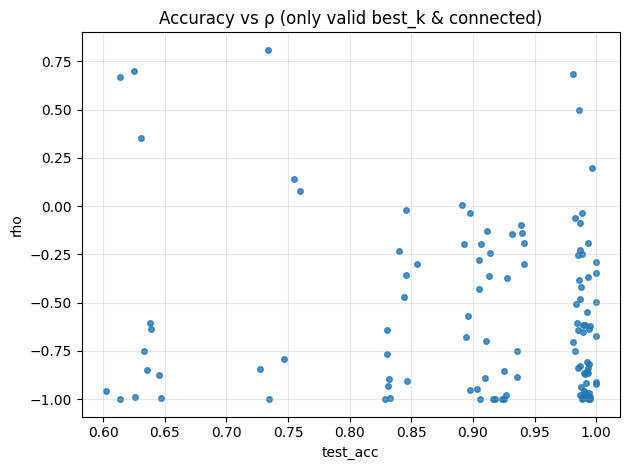

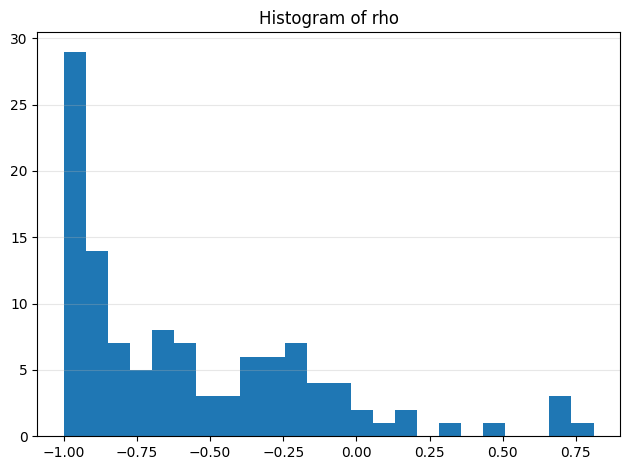

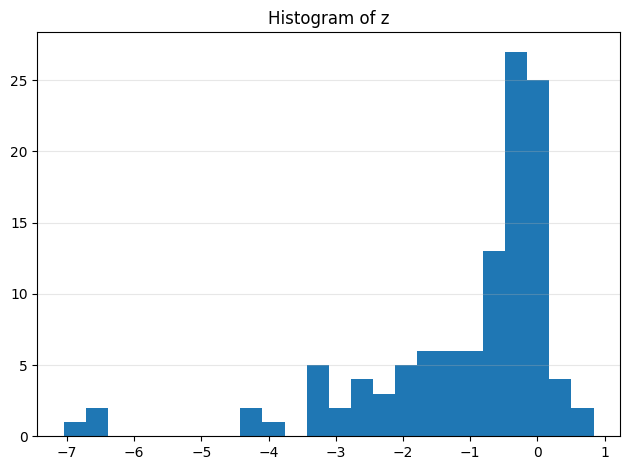

,dataset,mode,width,depth,test_acc,best_k,rho,z,connected_all_layers,run_id,error
1,cifar10_car_v_truck,real,bottleneck,11,0.754500,350,0.143047,0.058802,True,cifar10_car_v_truck__bottleneck__d11__s0,NaN
3,cifar10_car_v_truck,real,narrow,11,0.733500,10,0.810226,0.460376,True,cifar10_car_v_truck__w25__d11__s0,NaN
5,cifar10_car_v_truck,real,wide,11,0.760000,350,0.078610,0.032159,True,cifar10_car_v_truck__w50__d11__s0,NaN
7,cifar10_cat_v_dog,real,bottleneck,11,0.613500,350,0.671666,0.332221,True,cifar10_cat_v_dog__bottleneck__d11__s0,NaN
9,cifar10_cat_v_dog,real,narrow,11,0.625000,350,0.702643,0.356197,True,cifar10_cat_v_dog__w25__d11__s0,NaN
11,cifar10_cat_v_dog,real,wide,11,0.631000,350,0.352901,0.150543,True,cifar10_cat_v_dog__w50__d11__s0,NaN
16,fmnist_sandal_v_boot,real,wide,5,0.981500,250,0.683642,0.835921,True,fmnist_sandal_v_boot__w50__d5__s0,NaN
40,mnist_1v7,real,wide,5,0.996301,350,0.197756,0.200397,True,mnist_1v7__w50__d5__s0,NaN
52,mnist_3v5,real,wide,5,0.985804,250,0.497442,0.545902,True,mnist_3v5__w50__d5__s0,NaN
93,svhn_3v8,real,narrow,11,0.891457,350,0.008665,0.003538,True,svhn_3v8__w25__d11__s0,NaN


S:\cihan\tmp\ipykernel_21968\1329813945.py:154: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


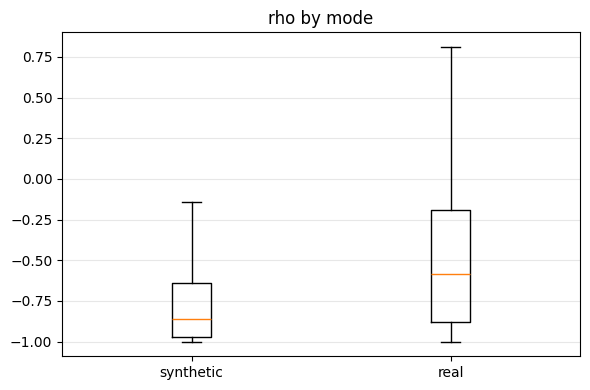

S:\cihan\tmp\ipykernel_21968\1329813945.py:154: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


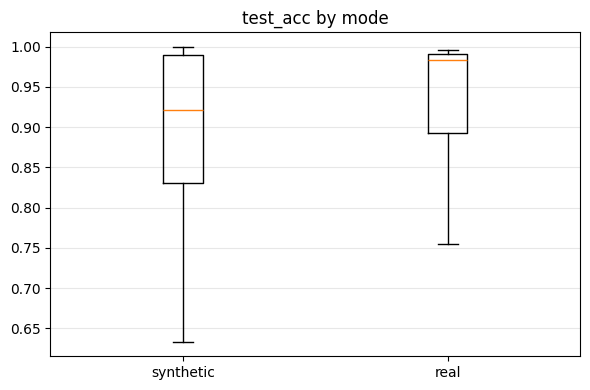

Saved artifacts -> S:\cihan\cihan\Ricci-Flow-Deep-Learning---Graduation-Project\report_artifacts
Per-dataset plots -> S:\cihan\cihan\Ricci-Flow-Deep-Learning---Graduation-Project\report_artifacts\per_dataset


In [45]:
#@title Report Collector (özet tablo + grafikler) — FIXED (connected bool parse + robustness)
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import json, time, os, re

ART = Path("report_artifacts"); ART.mkdir(exist_ok=True)
(ART / "per_dataset").mkdir(exist_ok=True, parents=True)

def _safe_read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception:
        return None

def _to_bool_series(s):
    """
    'True'/'False'/1/0/yes/no/NaN -> bool
    """
    if s is None:
        return pd.Series(dtype=bool)
    if s.dtype == bool:
        return s
    # string haritalama
    map_true  = {"true","1","yes","y","t"}
    map_false = {"false","0","no","n","f","nan","none",""}
    out = []
    for v in s.astype(str).str.strip().str.lower().tolist():
        if v in map_true:  out.append(True)
        elif v in map_false: out.append(False)
        else:
            # sayısal gibi görünüyorsa:
            try:
                out.append(bool(int(v)))
            except Exception:
                out.append(False)
    return pd.Series(out, index=s.index, dtype=bool)

# 1) Ana grid özeti
df = _safe_read_csv("ricci_summary.csv")
if df is None or df.empty:
    raise RuntimeError("ricci_summary.csv bulunamadı ya da boş. Grid runner veya tekil koşul çıktısı üretmelisin.")

# --- Uyum / eksik sütun dayanıklılığı ---
need_cols = ["dataset","test_acc","rho","z","best_k","connected_all_layers","mode","width","depth","run_id","error"]
for col in need_cols:
    if col not in df.columns:
        df[col] = np.nan

# 2) Temel temizleme
# sayısal dönüştürmeler (hata toleranslı)
for c in ["test_acc","rho","z","best_k","depth"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# width karışık tip olabilir (narrow/wide vs int liste). Raporda string kalsın:
df["width"] = df["width"].astype(str)

# connected_all_layers -> bool (ANA DÜZELTME)
df["connected_all_layers"] = _to_bool_series(df["connected_all_layers"])

# mode çıkarımı yoksa/eksikse üret:
def infer_mode(name: str):
    n = (name or "").lower()
    real_keys = ["mnist","fmnist","fashion","cifar","svhn","tiny","imagenet"]
    syn_keys  = ["synthetic","paper_syn","spiral","sine","moons","circles","blobs"]
    if any(k in n for k in real_keys) and not any(k in n for k in syn_keys):
        return "real"
    if any(k in n for k in syn_keys):
        return "synthetic"
    return "synthetic" if not re.search(r"(mnist|cifar|svhn|imagenet)", n) else "real"

if df["mode"].isna().all():
    df["mode"] = df["dataset"].astype(str).map(infer_mode)
else:
    df.loc[df["mode"].isna(), "mode"] = df.loc[df["mode"].isna(), "dataset"].astype(str).map(infer_mode)

# yeni yardımcı sütunlar
df["rho_abs"] = df["rho"].abs()
df["ok"] = df["best_k"].notna() & df["rho"].notna() & (df["connected_all_layers"] == True)

# 3) Dataset bazında özet (acc, rho, z ortalama)
g = df.groupby("dataset", dropna=False).agg(
    n=("dataset","size"),
    acc_mean=("test_acc","mean"),
    acc_std=("test_acc","std"),
    rho_mean=("rho","mean"),
    rho_std=("rho","std"),
    z_mean=("z","mean"),
    z_std=("z","std"),
    ok_ratio=("ok","mean"),
    k_med=("best_k","median"),
    k_min=("best_k","min"),
    k_max=("best_k","max"),
).reset_index()

# 'mode' sütununu rapora taşıyalım (left join) ve düzenleyelim
g = g.merge(df[["dataset","mode"]].drop_duplicates(), on="dataset", how="left")
cols = ["dataset","mode","n","acc_mean","acc_std","rho_mean","rho_std","z_mean","z_std","ok_ratio","k_min","k_med","k_max"]
g = g[cols].sort_values(["mode","dataset"], na_position="last")
g.to_csv(ART/"dataset_summary.csv", index=False)
display(g)

# 4) Mode × dataset bazında k ölçeği (synthetic vs real)
kstats = df[df["best_k"].notna()].groupby(["mode","dataset"], dropna=False).agg(
    k_med=("best_k","median"),
    k_min=("best_k","min"),
    k_max=("best_k","max")
).reset_index().sort_values(["mode","dataset"])
kstats.to_csv(ART/"kstats_by_dataset.csv", index=False)
display(kstats)

# 5) Scatter: accuracy vs rho (only valid)
plt.figure()
ok_mask = df["ok"].fillna(False)
plt.scatter(df.loc[ok_mask,"test_acc"], df.loc[ok_mask,"rho"], s=16, alpha=0.8)
plt.xlabel("test_acc"); plt.ylabel("rho")
plt.title("Accuracy vs ρ (only valid best_k & connected)")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(ART/"scatter_acc_vs_rho.png", dpi=150)
plt.show()

# 6) Histogram: rho ve z
for col in ["rho","z"]:
    v = df[col].dropna()
    if len(v) == 0:
        print(f"[skip] {col} boş.")
        continue
    plt.figure()
    plt.hist(v, bins=24)
    plt.title(f"Histogram of {col}")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(ART/f"hist_{col}.png", dpi=150)
    plt.show()

# 7) Pozitif rho / best=None anomalileri
anom = df[(df["rho"].notna() & (df["rho"]>0)) | df["best_k"].isna()]\
       .sort_values(["dataset","mode","width","depth"])
anom_cols = [c for c in ["dataset","mode","width","depth","test_acc","best_k","rho","z","connected_all_layers","run_id","error"] if c in df.columns]
anom.to_csv(ART/"anomalies.csv", index=False)
display(anom[anom_cols])

# 8) Mode bazlı kutu grafikleri (ρ ve accuracy)
for metric in ["rho","test_acc"]:
    vals_syn = df.loc[df["mode"]=="synthetic", metric].dropna()
    vals_real = df.loc[df["mode"]=="real", metric].dropna()
    if len(vals_syn)==0 and len(vals_real)==0:
        print(f"[skip] boxplot {metric}: veri yok.")
        continue
    plt.figure(figsize=(6,4))
    data = [vals_syn, vals_real]
    labels = ["synthetic","real"]
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(f"{metric} by mode")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(ART/f"box_{metric}_by_mode.png", dpi=150)
    plt.show()

# 9) Her dataset için mini rapor görselleri
by_ds = df.groupby("dataset", dropna=False)
for ds_name, sub in by_ds:
    ds_dir = ART / "per_dataset" / str(ds_name)
    ds_dir.mkdir(parents=True, exist_ok=True)
    valid = sub[sub["ok"].fillna(False)]

    # acc vs rho (tek dataset)
    if not valid.empty:
        plt.figure()
        plt.scatter(valid["test_acc"], valid["rho"], s=16, alpha=0.85)
        plt.xlabel("test_acc"); plt.ylabel("rho"); plt.grid(True, alpha=0.3)
        plt.title(f"{ds_name} — acc vs ρ (valid only)")
        plt.tight_layout()
        plt.savefig(ds_dir/"scatter_acc_vs_rho.png", dpi=150)
        plt.close()

        # k dağılımı
        if valid["best_k"].notna().any():
            plt.figure()
            plt.hist(valid["best_k"].dropna(), bins=20)
            plt.xlabel("best_k"); plt.ylabel("count"); plt.grid(True, alpha=0.3)
            plt.title(f"{ds_name} — best_k distribution")
            plt.tight_layout()
            plt.savefig(ds_dir/"hist_best_k.png", dpi=150)
            plt.close()

        # rho ve z histogramları
        for col in ["rho","z"]:
            v = valid[col].dropna()
            if len(v) > 0:
                plt.figure()
                plt.hist(v, bins=20)
                plt.title(f"{ds_name} — hist of {col}")
                plt.tight_layout()
                plt.savefig(ds_dir/f"hist_{col}.png", dpi=150)
                plt.close()

# 10) Küçük JSON özet
payload = {
    "generated_at": time.ctime(),
    "n_rows": int(len(df)),
    "datasets": sorted([str(x) for x in df["dataset"].dropna().unique().tolist()]),
    "synthetic_datasets": sorted([str(x) for x in df.loc[df["mode"]=="synthetic","dataset"].dropna().unique().tolist()]),
    "real_datasets": sorted([str(x) for x in df.loc[df["mode"]=="real","dataset"].dropna().unique().tolist()]),
    "acc_vs_rho_corr_all": float(df[["test_acc","rho"]].dropna().corr().iloc[0,1]) if df[["test_acc","rho"]].dropna().shape[0] > 2 else None,
    "acc_vs_rho_corr_valid": float(df.loc[df["ok"]==True, ["test_acc","rho"]].dropna().corr().iloc[0,1]) if df.loc[df["ok"]==True, ["test_acc","rho"]].dropna().shape[0] > 2 else None,
}
with open(ART/"quick_summary.json","w") as f:
    json.dump(payload, f, indent=2)
print("Saved artifacts ->", ART.resolve())
print("Per-dataset plots ->", (ART/"per_dataset").resolve())


In [46]:
#@title Ricci Suite: MNIST ikilileri + Paper Synthetic A/B/C + mevcut synthetic/CIFAR/SVHN (panel + tablo + CSV) — FIXED
# Guard: ProgressBoard/timed_step yoksa inline tanımla
try:
    ProgressBoard; timed_step
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    import time, pandas as pd, numpy as np
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]
        title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None
        t0: float = field(default_factory=time.time)
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            sort_cols = [c for c in ["dataset","width","depth","elapsed_s"] if c in df.columns]
            if sort_cols: df = df.sort_values(by=sort_cols, na_position='last')
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                elapsed = time.time() - self.t0
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {elapsed:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")
    def timed_step(fn, *args, **kwargs):
        t0 = time.time(); out = fn(*args, **kwargs); return out, round(time.time()-t0, 1)

# --- importlar & yardımcılar ---
from pathlib import Path
import re, time
import numpy as np, pandas as pd
from tensorflow.keras.datasets import mnist

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)

def _subset_digits_flat(x, y, pos, neg):
    sel = np.where((y==pos)|(y==neg))[0]
    X = x[sel].astype('float32')/255.0
    yb = (y[sel]==pos).astype('int64')  # pos sınıf = 1
    X = X.reshape((X.shape[0], -1))     # 28x28 -> 784
    return X, yb

def ensure_mnist_pair(a:int, b:int)->str:
    """mnist_{a}v{b}.npz varsa atla; yoksa oluştur ve kaydet. path döndürür."""
    name = f"mnist_{a}v{b}"
    p = DATA_DIR / f"{name}.npz"
    if p.exists():
        return str(p)
    (Xtr, ytr), (Xte, yte) = mnist.load_data()
    Xtr2, ytr2 = _subset_digits_flat(Xtr, ytr, a, b)
    Xte2, yte2 = _subset_digits_flat(Xte, yte, a, b)
    np.savez_compressed(p, X_train=Xtr2, y_train=ytr2, X_test=Xte2, y_test=yte2)
    print("saved", p, Xtr2.shape, Xte2.shape)
    return str(p)

MNIST_PAIR_RE = re.compile(r"^mnist_(\d)v(\d)$")

def get_npz_path(name:str)->str:
    """
    - 'mnist_{a}v{b}' biçimi ise gerekirse üretir, path döndürür.
    - Diğer isimler için data/{name}.npz varlığını kontrol eder.
    """
    m = MNIST_PAIR_RE.match(name)
    if m:
        a, b = int(m.group(1)), int(m.group(2))
        return ensure_mnist_pair(a, b)
    p = DATA_DIR / f"{name}.npz"
    if not p.exists():
        raise FileNotFoundError(f"data/{name}.npz bulunamadı. Önce dataset hücresini çalıştır.")
    return str(p)

# ---- mode & sample_size çıkarımı ----
def infer_mode_from_name(name: str) -> str:
    n = (name or "").lower()
    if any(k in n for k in ["mnist","fmnist","cifar","svhn","imagenet","tiny"]):
        return "real"
    if any(k in n for k in ["paper_syn","synthetic","moons","circles","blobs","spiral","sine"]):
        return "synthetic"
    return "synthetic"

def infer_sample_size(npz_path:str, cap:int=1000, mode:str=None)->int|None:
    """
    synthetic -> None (tam set); real -> min(cap, N_train)
    """
    if mode == "synthetic":
        return None
    d = np.load(npz_path)
    n_train = int(d["X_train"].shape[0])
    return int(min(cap, n_train))

# ---- k-sweep wrapper (2 veya 4 dönüş güvenli) ----
def _k_sweep_safe(run_id, layer_names, mode="synthetic", sample_size=None, rng_seed=0, conn_thresh=None):
    try:
        # conn_thresh varsa önce bu imzayı deneyelim
        if conn_thresh is not None:
            ret = auto_k_sweep_fast(run_id, layer_names, mode=mode, sample_size=sample_size,
                                    rng_seed=rng_seed, conn_thresh=conn_thresh)
        else:
            ret = auto_k_sweep_fast(run_id, layer_names, mode=mode, sample_size=sample_size,
                                    rng_seed=rng_seed)
    except TypeError:
        # Eski imza: positional
        if conn_thresh is not None:
            ret = auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed, conn_thresh)
        else:
            ret = auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed)

    # Dönüşü aç
    if isinstance(ret, tuple) and len(ret) == 2:
        res, best = ret
        ks = conn = None
    elif isinstance(ret, tuple) and len(ret) == 4:
        res, best, ks, conn = ret
    else:
        res, best, ks, conn = ret, None, None, None
    return res, best, ks, conn

# --- hedef veri setleri ---
# MNIST ikilileri
MNIST_PAIRS = ["mnist_4v7","mnist_1v5","mnist_2v6","mnist_6v7"]

# Paper synthetic (bu isimler dataset hücresinde üretildi)
PAPER_SYNTHETIC = [
    "paper_syn_A_sin_bands_1k_each",
    "paper_syn_B_two_spirals_1k_each",
    "paper_syn_C_sine_surface_vs_plane_1k_each",
]

# Mevcut synthetic/CIFAR/SVHN (dataset hücresinin ürettikleri)
OPTIONAL_EXISTING = [
    "synthetic_A_moons_1k_each",
    "synthetic_B_circles_1k_each",
    "synthetic_C_blobs_1k_each",
    "cifar10_cat_v_dog",
    "cifar10_car_v_truck",
    "svhn_1v7",
    "svhn_3v8",
]

# Birleştir (mevcut olup olmadığına göre filtreleyelim)
ALL_DATASET_NAMES = []
ALL_DATASET_NAMES += MNIST_PAIRS
ALL_DATASET_NAMES += PAPER_SYNTHETIC
for nm in OPTIONAL_EXISTING:
    if (DATA_DIR / f"{nm}.npz").exists():
        ALL_DATASET_NAMES.append(nm)

# --- mimari seti ---
WIDTHS = ["narrow","wide","bottleneck"]
DEPTHS = [5,11]

# --- panel hazırlığı ---
total = len(ALL_DATASET_NAMES)*len(WIDTHS)*len(DEPTHS)
board = ProgressBoard(
    columns=["dataset","width","depth","test_acc","best_k","rho","z",
             "connected_all_layers","elapsed_s","run_id","error"],
    title="Ricci Suite sweep", total=total
)

rows=[]
for name in ALL_DATASET_NAMES:
    try:
        ds_path = get_npz_path(name)
    except Exception as e:
        board.add(dataset=name, error=str(e), elapsed_s=np.nan)
        continue

    mode = infer_mode_from_name(name)  # DÜZELTME: mode otomatik
    for w in WIDTHS:
        for d in DEPTHS:
            t0 = time.time()
            try:
                # ---- Train ---- (DÜZELTME: seeds parametresi isimli)
                (train_out, train_sec) = timed_step(run_one, ds_path, w, d, 60, 128, 0)
                acc, run_id, layer_names = train_out

                # ---- Fast Ricci / k-sweep ----
                sample_size = infer_sample_size(ds_path, cap=1000, mode=mode)
                (kret, sweep_sec) = timed_step(_k_sweep_safe, run_id, layer_names, mode, sample_size, 0, 0.99)
                res, best, ks, conn = kret

                # best güvenli aç
                if best is None:
                    bk = brho = bz = bL = bconn = None
                else:
                    bk   = int(best[0]) if len(best) > 0 else None
                    brho = float(best[1]) if len(best) > 1 else None
                    bz   = float(best[2]) if len(best) > 2 else None
                    bL   = int(best[3]) if len(best) > 3 else None
                    bconn= bool(best[-1]) if len(best) > 4 else None

                row = dict(
                    dataset=name, width=w, depth=d,
                    test_acc=float(acc),
                    best_k=bk, rho=brho, z=bz,
                    connected_all_layers=(bconn if bconn is not None else False),
                    elapsed_s=round(time.time()-t0,1),
                    run_id=run_id
                )
                rows.append(row); board.add(**row)

            except Exception as e:
                row = dict(dataset=name, width=w, depth=d, error=str(e),
                           elapsed_s=round(time.time()-t0,1))
                rows.append(row); board.add(**row)

# -- final tablo & kaydet --
df_suite = pd.DataFrame(rows).sort_values(by=["dataset","width","depth"], na_position='last')
csv_out = Path("ricci_suite_summary.csv"); df_suite.to_csv(csv_out, index=False)
print("Saved ->", csv_out)
df_suite


=== Ricci Suite sweep ===


S:\cihan\tmp\ipykernel_21968\1006680986.py:90: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,dataset,width,depth,test_acc,best_k,rho,z,connected_all_layers,elapsed_s,run_id,error
70,cifar10_car_v_truck,bottleneck,5,NaN,NaN,NaN,NaN,NaN,16.2,NaN,SeedSequence expects int or sequence of ints f...
71,cifar10_car_v_truck,bottleneck,11,NaN,NaN,NaN,NaN,NaN,20.0,NaN,SeedSequence expects int or sequence of ints f...
66,cifar10_car_v_truck,narrow,5,NaN,NaN,NaN,NaN,NaN,14.1,NaN,SeedSequence expects int or sequence of ints f...
67,cifar10_car_v_truck,narrow,11,NaN,NaN,NaN,NaN,NaN,20.1,NaN,SeedSequence expects int or sequence of ints f...
68,cifar10_car_v_truck,wide,5,NaN,NaN,NaN,NaN,NaN,16.1,NaN,SeedSequence expects int or sequence of ints f...
...,...,...,...,...,...,...,...,...,...,...,...
59,synthetic_C_blobs_1k_each,bottleneck,11,NaN,NaN,NaN,NaN,NaN,8.6,NaN,SeedSequence expects int or sequence of ints f...
54,synthetic_C_blobs_1k_each,narrow,5,NaN,NaN,NaN,NaN,NaN,6.4,NaN,SeedSequence expects int or sequence of ints f...
55,synthetic_C_blobs_1k_each,narrow,11,NaN,NaN,NaN,NaN,NaN,10.6,NaN,SeedSequence expects int or sequence of ints f...
56,synthetic_C_blobs_1k_each,wide,5,NaN,NaN,NaN,NaN,NaN,6.3,NaN,SeedSequence expects int or sequence of ints f...


[Ricci Suite sweep] 84/84 = 100.0% | elapsed 19m57s | ETA ~0.0s

Completed per dataset:


,done
dataset,
cifar10_car_v_truck,6
cifar10_cat_v_dog,6
mnist_1v5,6
mnist_2v6,6
mnist_4v7,6
mnist_6v7,6
paper_syn_A_sin_bands_1k_each,6
paper_syn_B_two_spirals_1k_each,6
paper_syn_C_sine_surface_vs_plane_1k_each,6


Saved -> ricci_suite_summary.csv


,dataset,width,depth,error,elapsed_s
70,cifar10_car_v_truck,bottleneck,5,SeedSequence expects int or sequence of ints f...,16.2
71,cifar10_car_v_truck,bottleneck,11,SeedSequence expects int or sequence of ints f...,20.0
66,cifar10_car_v_truck,narrow,5,SeedSequence expects int or sequence of ints f...,14.1
67,cifar10_car_v_truck,narrow,11,SeedSequence expects int or sequence of ints f...,20.1
68,cifar10_car_v_truck,wide,5,SeedSequence expects int or sequence of ints f...,16.1
...,...,...,...,...,...
59,synthetic_C_blobs_1k_each,bottleneck,11,SeedSequence expects int or sequence of ints f...,8.6
54,synthetic_C_blobs_1k_each,narrow,5,SeedSequence expects int or sequence of ints f...,6.4
55,synthetic_C_blobs_1k_each,narrow,11,SeedSequence expects int or sequence of ints f...,10.6
56,synthetic_C_blobs_1k_each,wide,5,SeedSequence expects int or sequence of ints f...,6.3


In [47]:
#@title MLP-Arch + OPT/LR/LOSS destekli run_one_arch_opt (Keras 3 uyumlu) — FIXED (discovery + batch runner + logs)
# Guard: ProgressBoard yoksa inline tanımla
try:
    ProgressBoard; timed_step
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    import time, pandas as pd, numpy as np
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]; title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None; t0: float = field(default_factory=time.time)
        def add(self, **kwargs): self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            sort_cols = [c for c in ["dataset","width","depth","elapsed_s"] if c in df.columns]
            if sort_cols: df = df.sort_values(by=sort_cols, na_position='last')
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total; elapsed = time.time()-self.t0
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {elapsed:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")
    def timed_step(fn, *args, **kwargs):
        t0=time.time(); out=fn(*args, **kwargs); return out, round(time.time()-t0,1)

from pathlib import Path
import json, time, re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- Klasörler ----------
EMB_DIR  = Path("embeddings");  EMB_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR = Path("checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = Path("data");        DATA_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR = Path("logs");        LOGS_DIR.mkdir(parents=True, exist_ok=True)
RUNS_CSV = Path("runs_summary.csv")  # ana CSV (tüm koşular)

# ---------- activation / optimizer / loss helpers ----------
def get_activation_layer(name: str):
    name = name.lower()
    if name=="relu":  return layers.ReLU()
    if name=="gelu":  return layers.Activation(tf.keras.activations.gelu)
    if name in ("silu","swish"): return layers.Activation(tf.keras.activations.silu)
    if name=="tanh":  return layers.Activation("tanh")
    if name=="leakyrelu": return layers.LeakyReLU(negative_slope=0.1)  # Keras 3 uyumlu
    if name=="elu":   return layers.ELU(alpha=1.0)
    raise ValueError(f"Unsupported activation: {name}")

def get_optimizer(name: str, lr: float):
    name = name.lower()
    if name=="rmsprop": return keras.optimizers.RMSprop(learning_rate=lr)
    if name=="adam":    return keras.optimizers.Adam(learning_rate=lr)
    if name=="adamw":   return keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
    if name=="sgd":     return keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    raise ValueError(f"Unsupported optimizer: {name}")

def focal_loss(alpha=0.25, gamma=2.0, label_smoothing=0.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        if label_smoothing>0:
            y_true = y_true*(1-label_smoothing) + 0.5*label_smoothing
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1-eps)
        p_t = y_true*y_pred + (1-y_true)*(1-y_pred)
        alpha_t = y_true*alpha + (1-y_true)*(1-alpha)
        return tf.reduce_mean(-alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t))
    return loss

def make_hinge_loss(squared=False):
    # Etiketler 0/1; hinge {-1,+1} ister.
    def loss(y_true, y_pred):
        y = tf.cast(y_true, tf.float32)*2.0 - 1.0
        s = (y_pred*2.0 - 1.0)  # sigmoid çıktı -> skora yakın
        m = 1.0 - y*s
        m = tf.square(tf.maximum(0.0, m)) if squared else tf.maximum(0.0, m)
        return tf.reduce_mean(m)
    return loss

def get_loss(name: str):
    name = name.lower()
    if name in ("bce","binary_crossentropy"): return "binary_crossentropy"
    if name=="focal": return focal_loss(alpha=0.25, gamma=2.0)
    if name=="hinge": return make_hinge_loss(squared=False)
    if name in ("squared_hinge","hinge2"): return make_hinge_loss(squared=True)
    raise ValueError(f"Unsupported loss: {name}")

def _sanitize(s: str) -> str:
    return s.replace("/","_").replace("\\","_").replace(" ","_")

# ---------- model builder ----------
def build_mlp_arch(input_dim, width="narrow", depth=5,
                   activation="relu", batchnorm=False, dropout=0.0, residual=False):
    assert width in ["narrow","wide","bottleneck"]
    if residual and width=="bottleneck":
        residual=False  # boyut değişimi nedeniyle güvenli değil

    inputs = keras.Input(shape=(input_dim,))
    x = inputs; taps=[]; names=[]

    def block(x, units, i):
        z = layers.Dense(units, use_bias=(not batchnorm), name=f"dense_{i}_{units}")(x)
        if batchnorm: z = layers.BatchNormalization(name=f"bn_{i}")(z)
        z = get_activation_layer(activation)(z)
        if dropout and dropout>0: z = layers.Dropout(dropout, name=f"drop_{i}")(z)
        if residual and (x.shape[-1]==units):
            z = layers.Add(name=f"res_{i}")([x, z])
        taps.append(z); names.append(f"block{i}_{units}_{activation}{'_bn' if batchnorm else ''}{f'_do{dropout}' if dropout else ''}{'_res' if residual else ''}")
        return z

    if width=="bottleneck":
        units_list = [50,50,25,50,50] if depth==5 else [50,50,50,50,50,25,50,50,50,50,50]
    else:
        units_list = [25 if width=="narrow" else 50]*depth

    for i,u in enumerate(units_list,1): x = block(x,u,i)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)
    model = keras.Model(inputs, out)
    inter = keras.Model(inputs, taps)
    return model, inter, names

# ---------- tek koşu ----------
def run_one_arch_opt(dataset_npz, width, depth,
                     activation="relu", batchnorm=False, dropout=0.0, residual=False,
                     optimizer="rmsprop", lr=1e-3, loss="bce",
                     epochs=60, batch_size=128, seed=0,
                     standardize_small_dim=True):
    d = np.load(dataset_npz)
    Xtr,ytr,Xte,yte = d['X_train'], d['y_train'], d['X_test'], d['y_test']

    # Opsiyonel: küçük boyutlu sentetiklerde standardizasyon
    if standardize_small_dim and Xtr.shape[1] <= 10:
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler().fit(Xtr)
        Xtr = sc.transform(Xtr); Xte = sc.transform(Xte)

    tf.keras.utils.set_random_seed(seed)
    model, inter, layer_names = build_mlp_arch(
        Xtr.shape[1], width, depth, activation, batchnorm, dropout, residual
    )
    opt  = get_optimizer(optimizer, lr)
    los  = get_loss(loss)
    model.compile(optimizer=opt, loss=los, metrics=["accuracy"])

    _ = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                  epochs=epochs, batch_size=batch_size, verbose=0)
    te_loss, te_acc = model.evaluate(Xte, yte, verbose=0)
    emb_list = inter.predict(Xte, batch_size=1024, verbose=0)

    base = (
        Path(dataset_npz).stem
        + f"__{width}_d{depth}_act{activation}"
        + (f"_bn" if batchnorm else "")
        + (f"_do{dropout}" if dropout else "")
        + (f"_res" if residual else "")
        + f"__opt{optimizer}_lr{lr:g}_loss{loss}"
        + f"_seed{seed}"
    )
    out_dir = EMB_DIR / base; out_dir.mkdir(parents=True, exist_ok=True)
    for name, E in zip(layer_names, emb_list):
        np.save(out_dir / f"{_sanitize(name)}.npy", E)
    model.save(CKPT_DIR / f"{base}.keras")
    np.save(out_dir/"y_test.npy", yte); np.save(out_dir/"X_test.npy", Xte)
    return float(te_acc), base, layer_names

# ---------- discovery ----------
def list_npz_datasets(patterns=None, exclude_patterns=None):
    """
    data/ altındaki NPZ dosyalarını listeler. patterns -> adı 'içerir' filtresi.
    """
    files = sorted(DATA_DIR.glob("*.npz"))
    paths = [p for p in files]
    if patterns:
        paths = [p for p in paths if any(pat in p.stem for pat in patterns)]
    if exclude_patterns:
        paths = [p for p in paths if not any(pat in p.stem for pat in exclude_patterns)]
    return paths

def _infer_mode_from_name(name: str) -> str:
    n = name.lower()
    if any(k in n for k in ["mnist","fmnist","cifar","svhn","imagenet","tiny"]):
        return "real"
    if any(k in n for k in ["paper_syn","synthetic","moons","circles","blobs","spiral","sine"]):
        return "synthetic"
    return "synthetic"

def _infer_sample_size(npz_path: str, mode: str, cap:int=1000):
    if mode == "synthetic":
        return None
    with np.load(npz_path) as d:
        n_train = int(d["X_train"].shape[0])
    return int(min(cap, n_train))

# ---------- k-sweep güvenli çağrı ----------
def _k_sweep_safe(run_id, layer_names, mode="synthetic", sample_size=None, rng_seed=0, conn_thresh=0.99):
    """
    auto_k_sweep_fast farklı imzalarla olabilir; uyumlu wrapper.
    Dönüş: (res, best, ks, conn) — ks/conn olmayabilir -> None.
    """
    try:
        ret = auto_k_sweep_fast(run_id, layer_names,
                                mode=mode, sample_size=sample_size,
                                rng_seed=rng_seed, conn_thresh=conn_thresh)
    except TypeError:
        try:
            ret = auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed, conn_thresh)
        except TypeError:
            ret = auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed)
    if isinstance(ret, tuple) and len(ret)==2:
        res, best = ret; ks = conn = None
    elif isinstance(ret, tuple) and len(ret)==4:
        res, best, ks, conn = ret
    else:
        res, best, ks, conn = ret, None, None, None
    return res, best, ks, conn

# ---------- batch runner ----------
def _append_csv_row(csv_path: Path, row: dict, order_cols: list):
    df1 = pd.DataFrame([row])
    for c in order_cols:
        if c not in df1.columns: df1[c] = np.nan
    df1 = df1[order_cols]
    if not csv_path.exists():
        df1.to_csv(csv_path, index=False)
    else:
        df1.to_csv(csv_path, index=False, mode="a", header=False)

def run_batch(datasets,
              grid,
              epochs=60, batch_size=128, seed=0,
              board_title="Runs",
              do_k_sweep=True):
    """
    datasets: Path listesi (data/*.npz)
    grid: ya dict biçiminde {'width':[...],'depth':[...],'activation':[...],'optimizer':[...],'lr':[...],'loss':[...],
                            'batchnorm':[...],'dropout':[...],'residual':[...]}
          ya da her biri dict olan bir liste (hazır kombinasyonlar).
    """
    # --- grid'i normalize et ---
    from itertools import product
    if isinstance(grid, dict):
        grid = {k: (v if isinstance(v,(list,tuple)) else [v]) for k,v in grid.items()}
        keys = ["width","depth","activation","optimizer","lr","loss","batchnorm","dropout","residual"]
        for k in keys:
            grid.setdefault(k, [ {"width":"narrow","depth":5,"activation":"relu","optimizer":"rmsprop","lr":1e-3,"loss":"bce","batchnorm":False,"dropout":0.0,"residual":False}[k] ])
        combos = [dict(zip(keys, vals)) for vals in product(*[grid[k] for k in keys])]
    else:
        combos = list(grid)

    ORDER_COLS = ["dataset","mode","width","depth","activation","batchnorm","dropout","residual",
                  "optimizer","lr","loss","test_acc","best_k","rho","z","connected_all_layers",
                  "elapsed_s","run_id","error","session"]
    # session
    from datetime import datetime
    session = datetime.now().strftime("%Y%m%d_%H%M%S")
    sess_csv = LOGS_DIR / f"session_archopt_{session}.csv"

    total = len(datasets) * len(combos)
    board = ProgressBoard(
        columns=["dataset","width","depth","activation","optimizer","lr","loss","test_acc","best_k","rho","z","elapsed_s","run_id","error"],
        title=board_title, total=total
    )

    rows=[]
    for ds_path in datasets:
        ds_path = Path(ds_path)
        ds_name = ds_path.stem
        mode = _infer_mode_from_name(ds_name)
        per_ds_csv = LOGS_DIR / "by_dataset" / f"{ds_name}.csv"
        per_ds_csv.parent.mkdir(parents=True, exist_ok=True)

        for cfg in combos:
            t0=time.time()
            try:
                acc, run_id, layer_names = run_one_arch_opt(
                    str(ds_path),
                    width=cfg["width"], depth=int(cfg["depth"]),
                    activation=cfg["activation"],
                    batchnorm=bool(cfg["batchnorm"]),
                    dropout=float(cfg["dropout"]),
                    residual=bool(cfg["residual"]),
                    optimizer=cfg["optimizer"], lr=float(cfg["lr"]), loss=cfg["loss"],
                    epochs=epochs, batch_size=batch_size, seed=seed,
                    standardize_small_dim=True
                )
                # k-sweep (opsiyonel)
                bk=brho=bz=bconn=None
                if do_k_sweep:
                    ss = _infer_sample_size(str(ds_path), mode, cap=1000)
                    res, best, ks, conn = _k_sweep_safe(run_id, layer_names, mode=mode, sample_size=ss, rng_seed=0, conn_thresh=0.99)
                    if best is not None:
                        bk    = int(best[0]) if len(best)>0 else None
                        brho  = float(best[1]) if len(best)>1 else None
                        bz    = float(best[2]) if len(best)>2 else None
                        bconn = bool(best[-1]) if len(best)>4 else None

                row = dict(
                    dataset=ds_name, mode=mode,
                    width=cfg["width"], depth=int(cfg["depth"]),
                    activation=cfg["activation"], batchnorm=bool(cfg["batchnorm"]),
                    dropout=float(cfg["dropout"]), residual=bool(cfg["residual"]),
                    optimizer=cfg["optimizer"], lr=float(cfg["lr"]), loss=cfg["loss"],
                    test_acc=float(acc), best_k=bk, rho=brho, z=bz,
                    connected_all_layers=(bconn if bconn is not None else False),
                    elapsed_s=round(time.time()-t0,1),
                    run_id=run_id, error=np.nan, session=session
                )
                rows.append(row)
                # JSON meta (tek koşu) — logla
                meta = row.copy(); meta.update({"layer_names": layer_names, "npz": str(ds_path)})
                with open(LOGS_DIR / f"{run_id}.json","w",encoding="utf-8") as f:
                    json.dump(meta, f, indent=2)
                # CSV append
                _append_csv_row(per_ds_csv, row, ORDER_COLS)
                _append_csv_row(sess_csv, row, ORDER_COLS)
                _append_csv_row(RUNS_CSV, row, ORDER_COLS)
                board.add(**{k:row.get(k) for k in board.columns})

            except Exception as e:
                row = dict(
                    dataset=ds_name, mode=mode,
                    width=cfg.get("width"), depth=int(cfg.get("depth")),
                    activation=cfg.get("activation"), batchnorm=bool(cfg.get("batchnorm",False)),
                    dropout=float(cfg.get("dropout",0.0)), residual=bool(cfg.get("residual",False)),
                    optimizer=cfg.get("optimizer"), lr=float(cfg.get("lr",np.nan)), loss=cfg.get("loss"),
                    test_acc=np.nan, best_k=np.nan, rho=np.nan, z=np.nan,
                    connected_all_layers=False,
                    elapsed_s=round(time.time()-t0,1),
                    run_id="", error=str(e), session=session
                )
                rows.append(row)
                _append_csv_row(sess_csv, row, ORDER_COLS)
                _append_csv_row(RUNS_CSV, row, ORDER_COLS)
                board.add(**{k:row.get(k) for k in board.columns})

    df = pd.DataFrame(rows).sort_values(by=["dataset","width","depth","elapsed_s"], na_position="last")
    return df

# -------------------- ÖRNEK KULLANIM (yorum satırı) --------------------
ds_list = list_npz_datasets(
    patterns=["mnist_","paper_syn_A","paper_syn_B","paper_syn_C","synthetic_A","cifar10_cat_v_dog"],
    exclude_patterns=None
)
grid = dict(
    width=["narrow","wide"], depth=[5],
    activation=["relu","gelu"], batchnorm=[False], dropout=[0.0],
    residual=[False],
    optimizer=["rmsprop","adam"], lr=[1e-3], loss=["bce"]
)
df_runs = run_batch(ds_list, grid, epochs=40, batch_size=128, seed=0, board_title="Arch+Opt sweep", do_k_sweep=True)
display(df_runs.tail(10))


=== Arch+Opt sweep ===


S:\cihan\tmp\ipykernel_21968\1006680986.py:90: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,dataset,width,depth,activation,optimizer,lr,loss,test_acc,best_k,rho,z,elapsed_s,run_id,error
0,cifar10_cat_v_dog,narrow,5,relu,rmsprop,0.001,bce,0.5005,NaN,NaN,NaN,10.4,cifar10_cat_v_dog__narrow_d5_actrelu__optrmspr...,NaN
2,cifar10_cat_v_dog,narrow,5,gelu,rmsprop,0.001,bce,0.5005,NaN,NaN,NaN,10.7,cifar10_cat_v_dog__narrow_d5_actgelu__optrmspr...,NaN
3,cifar10_cat_v_dog,narrow,5,gelu,adam,0.001,bce,0.5965,10.0,-0.994558,-2.952041,29.9,cifar10_cat_v_dog__narrow_d5_actgelu__optadam_...,NaN
1,cifar10_cat_v_dog,narrow,5,relu,adam,0.001,bce,0.5860,200.0,-0.170303,-0.171978,30.1,cifar10_cat_v_dog__narrow_d5_actrelu__optadam_...,NaN
4,cifar10_cat_v_dog,wide,5,relu,rmsprop,0.001,bce,0.5005,NaN,NaN,NaN,11.5,cifar10_cat_v_dog__wide_d5_actrelu__optrmsprop...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,synthetic_A_moons_full10k,narrow,5,gelu,rmsprop,0.001,bce,0.9175,50.0,-0.946778,-1.799731,947.9,synthetic_A_moons_full10k__narrow_d5_actgelu__...,NaN
246,synthetic_A_moons_full10k,wide,5,gelu,rmsprop,0.001,bce,0.9161,6.0,-0.996697,-3.202229,936.6,synthetic_A_moons_full10k__wide_d5_actgelu__op...,NaN
247,synthetic_A_moons_full10k,wide,5,gelu,adam,0.001,bce,0.9173,6.0,-0.937067,-1.713427,939.9,synthetic_A_moons_full10k__wide_d5_actgelu__op...,NaN
245,synthetic_A_moons_full10k,wide,5,relu,adam,0.001,bce,0.9181,6.0,0.727312,0.922997,941.2,synthetic_A_moons_full10k__wide_d5_actrelu__op...,NaN


[Arch+Opt sweep] 248/248 = 100.0% | elapsed 4h09m | ETA ~0.0s

Completed per dataset:


,done
dataset,
cifar10_cat_v_dog,8
fmnist_sandal_v_boot,8
fmnist_shirt_v_coat,8
fmnist_tshirt_v_shirt,8
mnist_0v8,8
mnist_1v5,8
mnist_1v7,8
mnist_2v6,8
mnist_2v7,8


,dataset,mode,width,depth,activation,batchnorm,dropout,residual,optimizer,lr,loss,test_acc,best_k,rho,z,connected_all_layers,elapsed_s,run_id,error,session
237,synthetic_A_moons_1k_each,synthetic,wide,5,relu,False,0.0,False,adam,0.001,bce,0.9140,9.0,-0.993668,-2.876026,True,13.6,synthetic_A_moons_1k_each__wide_d5_actrelu__op...,NaN,20251008_003902
239,synthetic_A_moons_1k_each,synthetic,wide,5,gelu,False,0.0,False,adam,0.001,bce,0.9120,10.0,-0.999999,-7.151736,True,14.0,synthetic_A_moons_1k_each__wide_d5_actgelu__op...,NaN,20251008_003902
243,synthetic_A_moons_full10k,synthetic,narrow,5,gelu,False,0.0,False,adam,0.001,bce,0.9184,50.0,-0.903779,-1.492473,True,935.3,synthetic_A_moons_full10k__narrow_d5_actgelu__...,NaN,20251008_003902
241,synthetic_A_moons_full10k,synthetic,narrow,5,relu,False,0.0,False,adam,0.001,bce,0.9179,5.0,-0.952689,-1.860108,True,946.3,synthetic_A_moons_full10k__narrow_d5_actrelu__...,NaN,20251008_003902
240,synthetic_A_moons_full10k,synthetic,narrow,5,relu,False,0.0,False,rmsprop,0.001,bce,0.9154,5.0,-0.655585,-0.785032,True,947.4,synthetic_A_moons_full10k__narrow_d5_actrelu__...,NaN,20251008_003902
242,synthetic_A_moons_full10k,synthetic,narrow,5,gelu,False,0.0,False,rmsprop,0.001,bce,0.9175,50.0,-0.946778,-1.799731,True,947.9,synthetic_A_moons_full10k__narrow_d5_actgelu__...,NaN,20251008_003902
246,synthetic_A_moons_full10k,synthetic,wide,5,gelu,False,0.0,False,rmsprop,0.001,bce,0.9161,6.0,-0.996697,-3.202229,True,936.6,synthetic_A_moons_full10k__wide_d5_actgelu__op...,NaN,20251008_003902
247,synthetic_A_moons_full10k,synthetic,wide,5,gelu,False,0.0,False,adam,0.001,bce,0.9173,6.0,-0.937067,-1.713427,True,939.9,synthetic_A_moons_full10k__wide_d5_actgelu__op...,NaN,20251008_003902
245,synthetic_A_moons_full10k,synthetic,wide,5,relu,False,0.0,False,adam,0.001,bce,0.9181,6.0,0.727312,0.922997,True,941.2,synthetic_A_moons_full10k__wide_d5_actrelu__op...,NaN,20251008_003902
244,synthetic_A_moons_full10k,synthetic,wide,5,relu,False,0.0,False,rmsprop,0.001,bce,0.9163,5.0,-0.107668,-0.108087,True,944.2,synthetic_A_moons_full10k__wide_d5_actrelu__op...,NaN,20251008_003902


In [48]:
#@title Training Config SearchCV (GENİŞLETİLMİŞ: grid/random, geniş parametre yelpazesi)
from pathlib import Path
import numpy as np, pandas as pd, time, math, json, itertools, random, re
from IPython.display import display

# ---- ProgressBoard guard ----
try:
    ProgressBoard
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]; title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None; t0: float = time.time()
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            display(df.tail(15))
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {time.time()-self.t0:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")

# ---- dataset listesi (sabit + auto-discovery) ----
DATASETS_FIXED = [
  ("data/synthetic_A_moons_1k_each.npz","synthetic"),
  ("data/mnist_1v7.npz","real"),
  ("data/fmnist_sandal_v_boot.npz","real"),
  ("data/cifar10_car_v_truck.npz","real"),
  ("data/svhn_1v7.npz","real"),
  ("data/paper_syn_A_sin_bands_1k_each.npz","synthetic"),
  ("data/paper_syn_B_two_spirals_1k_each.npz","synthetic"),
  ("data/paper_syn_C_sine_surface_vs_plane_1k_each.npz","synthetic"),
]

def _auto_discover_npz(data_dir="data"):
    keep_pat = re.compile(r"(paper_syn_|synthetic_|mnist_|fmnist_|cifar10_|svhn_)")
    out=[]
    pdir = Path(data_dir)
    if not pdir.exists(): return out
    for p in sorted(pdir.glob("*.npz")):
        stem = p.stem
        if not keep_pat.search(stem): continue
        mode = "real" if any(k in stem for k in ["mnist","fmnist","cifar","svhn"]) else "synthetic"
        out.append((str(p), mode))
    return out

DATASETS = list({(d,m) for (d,m) in (DATASETS_FIXED + _auto_discover_npz())})  # tekilleştir

# ---- yardımcılar ----
def _sample_size_for(mode, ds_name):
    if mode=='synthetic': return None
    return 1200 if ds_name.startswith(("cifar10","svhn")) else 800

def _k_sweep_safe(run_id, layer_names, mode, sample_size, rng_seed=0, conn_thresh=0.99):
    # İmza farklılıklarına dayanıklı
    try:
        ret = auto_k_sweep_fast(run_id, layer_names, mode=mode, sample_size=sample_size,
                                rng_seed=rng_seed, conn_thresh=conn_thresh)
    except TypeError:
        try:
            ret = auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed, conn_thresh)
        except TypeError:
            ret = auto_k_sweep_fast(run_id, layer_names, mode, sample_size, rng_seed)
    if isinstance(ret, tuple) and len(ret)==2:
        res, best = ret; ks=conn=None
    elif isinstance(ret, tuple) and len(ret)==4:
        res, best, ks, conn = ret
    else:
        res, best, ks, conn = ret, None, None, None
    return res, best, ks, conn

def _param_iter(param_grid, mode="grid", n_iter=None, random_state=0):
    rnd = random.Random(random_state)
    keys = list(param_grid.keys())
    values = [v if isinstance(v,(list,tuple)) else [v] for v in (param_grid[k] for k in keys)]
    pool = list(itertools.product(*values))
    if mode=="grid":
        for combo in pool: yield dict(zip(keys, combo))
    else:
        n = len(pool) if n_iter is None else min(n_iter, len(pool))
        for idx in rnd.sample(range(len(pool)), n):
            yield dict(zip(keys, pool[idx]))

def _score(row, scoring="z"):
    acc = row.get("test_acc"); z = row.get("z")
    if scoring == "acc":
        return float(acc) if acc is not None and not math.isnan(acc) else -1e9
    if scoring == "z":
        return abs(float(z)) if z is not None and not math.isnan(z) else -1e9
    if scoring == "combo":
        z_norm = 0.0 if z is None or math.isnan(z) else min(abs(float(z))/4.0, 1.5)
        a_norm = 0.0 if acc is None or math.isnan(acc) else float(acc)
        return 0.7*a_norm + 0.3*z_norm
    return -1e9

# ---- GENİŞ PARAMETRE IZGARASI ----
param_grid = dict(
    width=["narrow","wide","bottleneck"],
    depth=[5,11],
    activation=["relu","gelu","silu","tanh","leakyrelu","elu"],
    batchnorm=[False, True],
    dropout=[0.0, 0.1, 0.2, 0.3, 0.5],
    residual=[False, True],            # bottleneck’te otomatik kapatılır
    optimizer=["rmsprop","adam","adamw","sgd"],
    lr=[1e-2, 5e-3, 1e-3, 5e-4, 3e-4, 1e-4],
    loss=["bce","focal","hinge","squared_hinge"],
    # Opsiyonel eğitim hiperparametreleri (istersen aç)
    epochs=[60, 40],
    batch_size=[128, 256],
)

# ---- ana arama fonksiyonu ----
def search_train_configs(
    datasets=DATASETS,
    param_grid=param_grid,
    mode="random",          # "grid" çok büyük olur; varsayılan "random"
    n_iter=120,             # rastgele örnekleme sayısı (her dataset için)
    seed=0,
    scoring="z",            # "acc" | "z" | "combo"
    random_state=0,
    save_csv="ricci_training_config_search_wide.csv"
):
    # toplam adım tahmini
    n_cfg = sum(1 for _ in _param_iter(param_grid, mode=mode, n_iter=n_iter, random_state=random_state))
    total = len(datasets) * n_cfg
    board = ProgressBoard(
        columns=["dataset","activation","batchnorm","dropout","residual",
                 "optimizer","lr","loss","width","depth","epochs","batch_size",
                 "test_acc","best_k","rho","z","score","elapsed_s","run_id","error"],
        title=f"Config Search ({mode}, n_iter={n_iter})", total=total
    )

    rows=[]; best_per_ds={}
    for ds, ds_mode in datasets:
        ds_name = Path(ds).stem
        ss = _sample_size_for(ds_mode, ds_name)
        for cfg in _param_iter(param_grid, mode=mode, n_iter=n_iter, random_state=random_state):
            t0 = time.time()
            try:
                # eğitim hiperparametrelerini config’ten al
                epochs   = int(cfg.get("epochs", 60))
                bsize    = int(cfg.get("batch_size", 128))

                acc, run_id, lns = run_one_arch_opt(
                    ds, cfg["width"], int(cfg["depth"]),
                    activation=cfg["activation"], batchnorm=bool(cfg["batchnorm"]),
                    dropout=float(cfg["dropout"]), residual=bool(cfg["residual"]),
                    optimizer=cfg["optimizer"], lr=float(cfg["lr"]), loss=cfg["loss"],
                    epochs=epochs, batch_size=bsize, seed=seed,
                    standardize_small_dim=True
                )

                _, best, _, _ = _k_sweep_safe(run_id, lns, mode=ds_mode, sample_size=ss, rng_seed=0, conn_thresh=0.99)

                row = dict(
                    dataset=ds_name,
                    activation=cfg["activation"], batchnorm=bool(cfg["batchnorm"]),
                    dropout=float(cfg["dropout"]), residual=bool(cfg["residual"]),
                    optimizer=cfg["optimizer"], lr=float(cfg["lr"]), loss=cfg["loss"],
                    width=cfg["width"], depth=int(cfg["depth"]),
                    epochs=epochs, batch_size=bsize,
                    test_acc=float(acc),
                    best_k=(int(best[0]) if best else None),
                    rho=(float(best[1]) if best else None) if best else None,
                    z=(float(best[2]) if best else None) if best else None,
                    run_id=run_id,
                    elapsed_s=round(time.time()-t0,1),
                )
                row["score"] = _score(row, scoring=scoring)
                rows.append(row); board.add(**{**row, "error": np.nan})

                bp = best_per_ds.get(ds_name)
                if (bp is None) or (row["score"] > bp[0]):
                    best_per_ds[ds_name] = (row["score"], row)

            except Exception as e:
                row = dict(
                    dataset=ds_name,
                    activation=cfg.get("activation"), batchnorm=bool(cfg.get("batchnorm",False)),
                    dropout=float(cfg.get("dropout",0.0)), residual=bool(cfg.get("residual",False)),
                    optimizer=cfg.get("optimizer"), lr=float(cfg.get("lr",np.nan)), loss=cfg.get("loss"),
                    width=cfg.get("width"), depth=int(cfg.get("depth",5)),
                    epochs=int(cfg.get("epochs",60)), batch_size=int(cfg.get("batch_size",128)),
                    test_acc=np.nan, best_k=np.nan, rho=np.nan, z=np.nan,
                    score=-1e9, run_id="", elapsed_s=round(time.time()-t0,1)
                )
                rows.append(row); board.add(**{**row, "error": str(e)})

    df = pd.DataFrame(rows).sort_values(by=["dataset","score","test_acc"], ascending=[True,False,False], na_position='last')
    out_csv = Path(save_csv); df.to_csv(out_csv, index=False)
    print("Saved ->", out_csv)

    if len(df)>0:
        best_rows = []
        for ds_name, (sc, row) in best_per_ds.items():
            best_rows.append(row)
        if best_rows:
            df_best = pd.DataFrame(best_rows).sort_values(by=["dataset"])
            print("\nBest per dataset:")
            display(df_best[["dataset","activation","batchnorm","dropout","residual","optimizer","lr","loss",
                             "width","depth","epochs","batch_size","test_acc","z","score","run_id"]])
    return df

# ---------- ÇALIŞTIRMA ÖRNEĞİ ----------
# Not: çok geniş grid olduğundan default 'random' ve n_iter=120 verilmiştir.
# İstersen mode="grid" yapabilirsin (kombinasyon sayısı çok büyük olabilir).
# df_wide = search_train_configs(mode="random", n_iter=120, scoring="combo", save_csv="ricci_config_search_wide.csv")


## Görselleştirme Kısmı

In [49]:
#@title VIZ SETUP — son koşuyu seç, özet tabloyu göster
from pathlib import Path
import json, numpy as np, pandas as pd
from IPython.display import display

LOGS_DIR = Path("logs")
EMB_ROOT = Path("embeddings")

def _gather_runs():
    rows = []
    for jf in sorted((LOGS_DIR).glob("*.json")):
        meta = json.loads(Path(jf).read_text(encoding="utf-8"))
        rows.append({
            "run_id": jf.stem,
            "dataset": Path(meta.get("dataset","")).stem,
            "width": meta.get("width"),
            "depth": meta.get("depth"),
            "seed": meta.get("seed"),
            "epochs": meta.get("epochs"),
            "batch_size": meta.get("batch_size"),
            "standardize": meta.get("standardize"),
            "test_acc": meta.get("acc"),
        })
    return pd.DataFrame(rows).sort_values(["dataset","depth","seed"])

df_runs = _gather_runs()
if df_runs.empty:
    raise FileNotFoundError("Hiç koşu meta bulunamadı (logs/*.json). Önce run_cycle / run_one çalıştır.")

display(df_runs.tail(10))

# Son koşu id'si (istersen elle değiştir)
run_id = df_runs.iloc[-1]["run_id"]
emb_dir = EMB_ROOT / run_id
print("Seçilen run_id:", run_id)
print("Embeddings klasörü:", emb_dir)

# test etiketlerini yükle
y_path = emb_dir / "y_test.npy"
if not y_path.exists():
    raise FileNotFoundError(f"{y_path} yok. run_one içinde embeddings kaydı yapılmış olmalı.")
y_test = np.load(y_path).reshape(-1)

# katman isimleri: json’dan ya da klasörden
meta = json.loads((LOGS_DIR / f"{run_id}.json").read_text(encoding="utf-8"))
layer_names = meta.get("layer_names")
if not layer_names:
    layer_names = [p.stem for p in sorted(emb_dir.glob("*.npy")) if p.stem not in ("y_test","mu","sd")]
print("Katman sayısı:", len(layer_names))


,run_id,dataset,width,depth,seed,epochs,batch_size,standardize,test_acc
447,synthetic_B_circles_1k_each__w50__d5__s0,synthetic_B_circles_1k_each,50,5,0.0,60.0,128.0,True,0.982
442,synthetic_B_circles_1k_each__bottleneck__d11__s0,synthetic_B_circles_1k_each,"[50, 25, 50]",11,0.0,60.0,128.0,True,0.966
444,synthetic_B_circles_1k_each__w25__d11__s0,synthetic_B_circles_1k_each,25,11,0.0,60.0,128.0,True,0.981
446,synthetic_B_circles_1k_each__w50__d11__s0,synthetic_B_circles_1k_each,50,11,0.0,60.0,128.0,True,0.980
449,synthetic_C_blobs_1k_each__bottleneck__d5__s0,synthetic_C_blobs_1k_each,"[50, 25, 50]",5,0.0,60.0,128.0,True,0.827
451,synthetic_C_blobs_1k_each__w25__d5__s0,synthetic_C_blobs_1k_each,25,5,0.0,60.0,128.0,True,0.831
453,synthetic_C_blobs_1k_each__w50__d5__s0,synthetic_C_blobs_1k_each,50,5,0.0,60.0,128.0,True,0.828
448,synthetic_C_blobs_1k_each__bottleneck__d11__s0,synthetic_C_blobs_1k_each,"[50, 25, 50]",11,0.0,60.0,128.0,True,0.827
450,synthetic_C_blobs_1k_each__w25__d11__s0,synthetic_C_blobs_1k_each,25,11,0.0,60.0,128.0,True,0.825
452,synthetic_C_blobs_1k_each__w50__d11__s0,synthetic_C_blobs_1k_each,50,11,0.0,60.0,128.0,True,0.829


Seçilen run_id: synthetic_C_blobs_1k_each__w50__d11__s0
Embeddings klasörü: embeddings\synthetic_C_blobs_1k_each__w50__d11__s0
Katman sayısı: 11


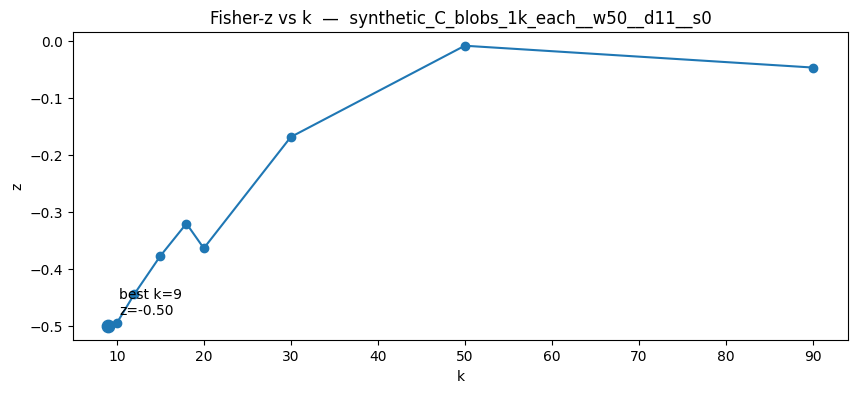

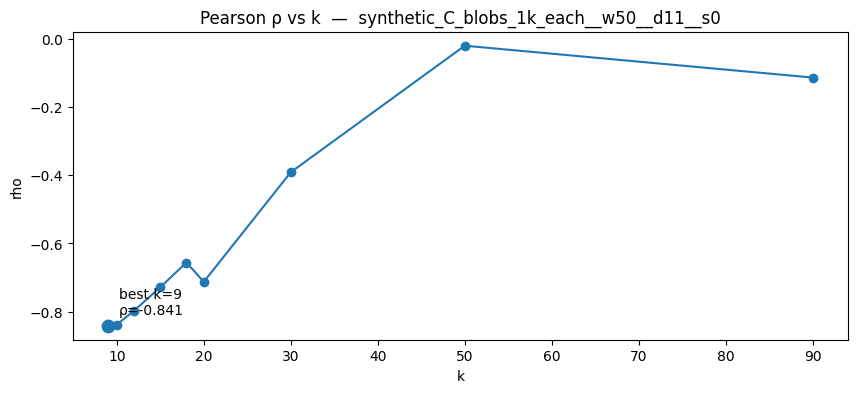

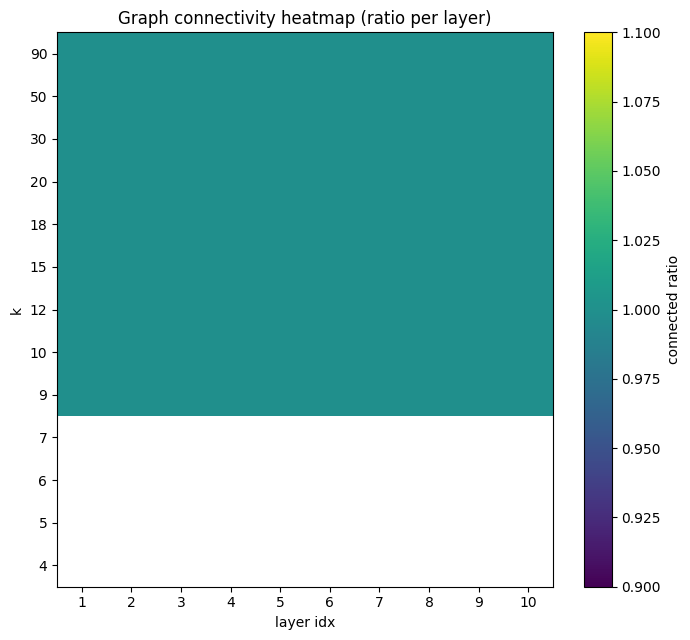

BEST: (9, -0.8412754734379917, -0.5003171879914698, 10, True)


In [50]:
#@title K-SWEEP — rho/z eğrileri + en iyi k + (varsa) bağlılık ısı haritası
import numpy as np, matplotlib.pyplot as plt

def _unpack_k_sweep(ret):
    if not isinstance(ret, tuple): return None, None, None, None
    if len(ret)==2: res,best = ret; return res,best,None,None
    if len(ret)==4: res,best,ks,conn = ret; return res,best,ks,conn
    return None, None, None, None

# run_id, layer_names VIZ SETUP'tan geliyor
res, best, ks, conn = _unpack_k_sweep(
    auto_k_sweep_fast(run_id, layer_names, mode="synthetic" if "syn" in run_id else "real",
                      sample_size=None, rng_seed=0)
)

if res is None or len(res)==0:
    raise RuntimeError("k-sweep sonuçları boş.")

# liste → dizi
K   = np.array([t[0] for t in res], dtype=int)
RHO = np.array([t[1] for t in res], dtype=float)
Z   = np.array([t[2] for t in res], dtype=float)

fig = plt.figure(figsize=(10,4))
# z
plt.plot(K, Z, marker="o")
plt.title(f"Fisher-z vs k  —  {run_id}")
plt.xlabel("k"); plt.ylabel("z")
# best'i işaretle
if best is not None:
    plt.scatter([best[0]],[best[2]], s=80)
    plt.annotate(f"best k={best[0]}\nz={best[2]:.2f}", (best[0],best[2]),
                 xytext=(8,8), textcoords="offset points")
plt.show()

# rho
plt.figure(figsize=(10,4))
plt.plot(K, RHO, marker="o")
plt.title(f"Pearson ρ vs k  —  {run_id}")
plt.xlabel("k"); plt.ylabel("rho")
if best is not None:
    plt.scatter([best[0]],[best[1]], s=80)
    plt.annotate(f"best k={best[0]}\nρ={best[1]:.3f}", (best[0],best[1]),
                 xytext=(8,8), textcoords="offset points")
plt.show()

# (opsiyonel) bağlılık ısı haritası
if conn is not None:
    # conn: {k: [ratio_per_layer]} veya benzeri — esnek çizim
    import numpy as np
    ks_sorted = sorted(conn.keys())
    M = max(len(conn[k]) for k in ks_sorted)
    A = np.full((len(ks_sorted), M), np.nan, dtype=float)
    for i,k in enumerate(ks_sorted):
        v = np.array(conn[k], dtype=float)
        A[i,:len(v)] = v
    plt.figure(figsize=(8, 0.4*len(ks_sorted)+2))
    plt.imshow(A, aspect="auto", origin="lower")
    plt.colorbar(label="connected ratio")
    plt.yticks(range(len(ks_sorted)), ks_sorted)
    plt.xticks(range(M), range(1,M+1))
    plt.xlabel("layer idx"); plt.ylabel("k")
    plt.title("Graph connectivity heatmap (ratio per layer)")
    plt.show()
else:
    print("conn bilgisi yok → heatmap atlandı.")

print("BEST:", best)


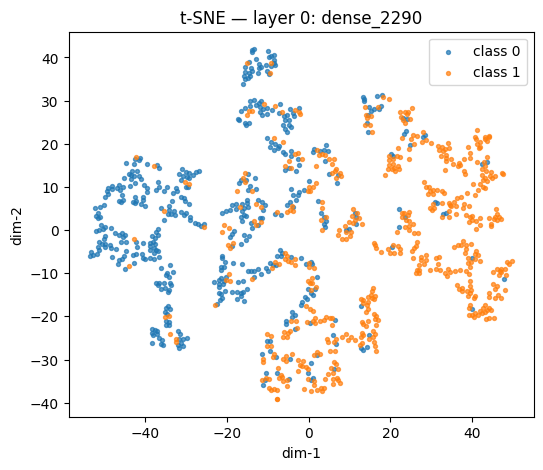

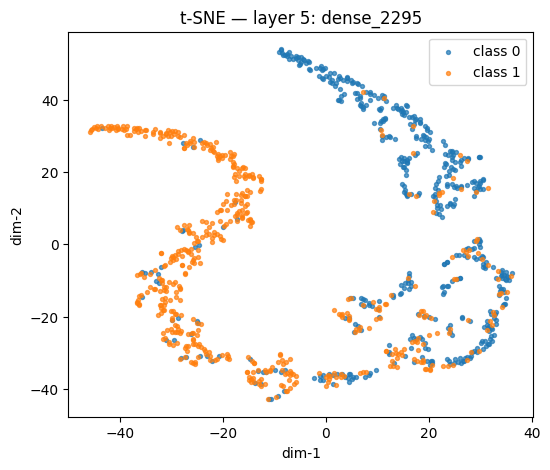

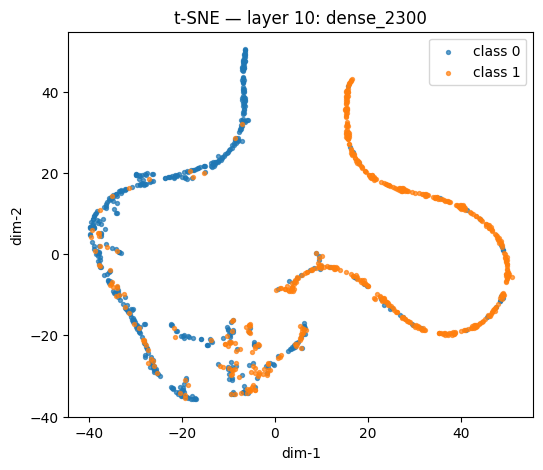

In [51]:
#@title EMBEDDING 2D — t-SNE (ilk/orta/son katman)
import numpy as np, matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def _pick_layers(names):
    if len(names) == 0: return []
    idx0 = 0
    idxm = len(names)//2
    idxL = len(names)-1
    idxs = sorted(set([idx0, idxm, idxL]))
    return [(i, names[i]) for i in idxs]

picks = _pick_layers(layer_names)
if not picks:
    raise RuntimeError("Katman isimleri boş.")

for i,name in picks:
    Z = np.load(emb_dir / f"{name}.npy")
    # hızlı t-SNE (perplexity dataset boyutuna göre sınırla)
    n = len(Z)
    perp = min(30, max(5, n//50))
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=perp)
    xy = tsne.fit_transform(Z)

    plt.figure(figsize=(6,5))
    # sınıflar 0/1 varsayımı — renk ayrımı:
    cls0 = y_test == 0
    cls1 = y_test == 1
    plt.scatter(xy[cls0,0], xy[cls0,1], s=8, alpha=0.7, label="class 0")
    plt.scatter(xy[cls1,0], xy[cls1,1], s=8, alpha=0.7, label="class 1")
    plt.legend(loc="best")
    plt.title(f"t-SNE — layer {i}: {name}")
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    plt.show()


,dataset,mode,width,depth,test_acc,best_k,rho,z,L,connected_all_layers,elapsed_s,run_id,error,session
102,svhn_1v7,real,narrow,5,0.936078,10,-0.885384,-1.400151,4,True,49.3,svhn_1v7__w25__d5__s0,NaN,20251007_220339
103,svhn_1v7,real,narrow,11,0.941416,350,-0.300234,-0.126466,10,True,100.0,svhn_1v7__w25__d11__s0,NaN,20251007_220339
104,svhn_1v7,real,wide,5,0.939590,30,-0.137707,-0.138587,4,True,53.0,svhn_1v7__w50__d5__s0,NaN,20251007_220339
105,svhn_1v7,real,wide,11,0.938887,350,-0.098369,-0.040289,10,True,101.6,svhn_1v7__w50__d11__s0,NaN,20251007_220339
106,svhn_1v7,real,bottleneck,5,0.935656,350,-0.752320,-0.978280,4,True,53.1,svhn_1v7__bottleneck__d5__s0,NaN,20251007_220339
107,svhn_1v7,real,bottleneck,11,0.941276,350,-0.191929,-0.079339,10,True,101.8,svhn_1v7__bottleneck__d11__s0,NaN,20251007_220339
108,svhn_3v8,real,narrow,5,0.895861,120,-0.567797,-0.644266,4,True,45.4,svhn_3v8__w25__d5__s0,NaN,20251007_220339
109,svhn_3v8,real,narrow,11,0.891457,350,0.008665,0.003538,10,True,92.9,svhn_3v8__w25__d11__s0,NaN,20251007_220339
110,svhn_3v8,real,wide,5,0.905108,250,-0.430184,-0.460123,4,True,50.0,svhn_3v8__w50__d5__s0,NaN,20251007_220339
111,svhn_3v8,real,wide,11,0.911713,350,-0.127505,-0.052338,10,True,96.7,svhn_3v8__w50__d11__s0,NaN,20251007_220339


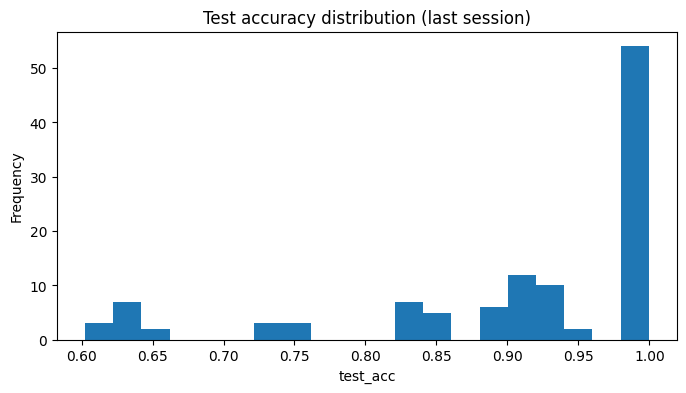

In [52]:
#@title Hızlı rapor — session/DS logları ve accuracy histogram
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# varsa son session csv’sini bul
sess_dir = Path("logs/sessions")
session_csvs = sorted(sess_dir.glob("session_*.csv"))
if session_csvs:
    df_sess = pd.read_csv(session_csvs[-1])
    display(df_sess.tail(12))
    plt.figure(figsize=(8,4))
    df_sess["test_acc"].dropna().plot(kind="hist", bins=20)
    plt.title("Test accuracy distribution (last session)")
    plt.xlabel("test_acc"); plt.show()
else:
    print("Session CSV yok. Sadece ricci_summary.csv deneniyor.")
    p = Path("ricci_summary.csv")
    if p.exists():
        df = pd.read_csv(p)
        display(df.tail(12))
        plt.figure(figsize=(8,4))
        df["test_acc"].dropna().plot(kind="hist", bins=20)
        plt.title("Test accuracy distribution (ricci_summary)")
        plt.xlabel("test_acc"); plt.show()
    else:
        print("ricci_summary.csv de yok, önce grid runner çalıştır.")


In [53]:
#@title KATMAN TRENDLERİ — Forman-Ricci & geodezik (layer idx)
import numpy as np, matplotlib.pyplot as plt

# Bu fonksiyonlar sende zaten varsa kullanılacak; yoksa kibarca atlar.
try:
    Ric_list = compute_total_forman_ricci_over_layers(emb_dir, k=15)
    Geo_list = compute_total_geodesic_over_layers(emb_dir, k=15)

    L = len(Ric_list)
    xs = np.arange(1, L+1)

    plt.figure(figsize=(10,4))
    plt.plot(xs, Ric_list, marker="o")
    plt.title(f"Total Forman-Ricci over layers — {run_id}")
    plt.xlabel("layer idx"); plt.ylabel("Σ Ricci")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(xs, Geo_list, marker="o")
    plt.title(f"Total geodesic over layers — {run_id}")
    plt.xlabel("layer idx"); plt.ylabel("Σ geodesic")
    plt.show()

except NameError:
    print("compute_total_* fonksiyonları tanımlı değil; bu hücre trend çizimini atladı.")


compute_total_* fonksiyonları tanımlı değil; bu hücre trend çizimini atladı.
